# 1. Import Required Libraries

## Data Overview
Taken data from Google Analytics Customer Revenue Prediction on kaggle https://www.kaggle.com/c/ga-customer-revenue-prediction/overview/description

We are given two datasets:-

- train.csv
 
- test.csv
Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

In [1]:
#Importing Libraries

import warnings 
warnings.filterwarnings("ignore") #to ignore warning messages
import pandas as pd #create small dataframes 
import json         # to parse JSON Columns
from pandas.io.json import json_normalize #Library to normalize semi-structured JSON data into a flat table.
import os           
import matplotlib.pylab as plt
import numpy as np 
import plotly.graph_objects as go #Graphing library. 
import gc           #Garbage Collector interface
gc.enable() #Enable automatic garbage collection.

import lightgbm as lgb # Light GBM model
from sklearn.model_selection import RandomizedSearchCV ,GridSearchCV #Hypertune parameters for model
from datetime import datetime, timedelta #The datetime module supplies classes for manipulating dates and times.
from sklearn import preprocessing #Will use this library to label encode categorical features.
import category_encoders as ce #category encoder

# 1.1 Train and Test Data Loading

=> Train Dataset is of 25.4 GB. So, we have used Google Cloud instance with 50 GB main memory to process it.

=> While Reading the dataset, we would be using Chunksize of 100000 to optimize performance.

=> Also, will drop unneccessary columns (columns with constant value or those which adds minimal value) to reduce memory usage.

In [6]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10038/180088/compressed/train_v2.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1604838799&Signature=NEsmvjRpRmr%2FuVFVK3Uuj5OhfFg1c4Yfr8nLZpqM%2FFJLg6z4g%2FbXptqjM5KFd2OTgiKcGOGiU6lRW%2FnSm0LuIsbLFgkC49hLvhawaNuMX2GLxuuaBxmlBk%2FpipntaTGWKsYSUkRUDDKjh5kVyLyYUVtpgwPspCV27wVYhBdj3QY9Wg%2B2PRqnps%2Bve8jnmVSVez3p02nrMtZa4nbcKgI7q5%2Beno7n7EK9KmODIeKvtczmE9Pwku24wtSwYOC2Se7Oe3L8XRGi4cO3mNlPGbSqkZ8INLGqq1Aq0%2FbSl%2FBDsp7%2FmndXtfKneDCyc0T8Vas4d3GATAYIJc845gBrRJUPRA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_v2.csv.zip" -c -O 'train_v2.csv.zip'

--2020-11-06 12:49:09--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10038/180088/compressed/train_v2.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1604838799&Signature=NEsmvjRpRmr%2FuVFVK3Uuj5OhfFg1c4Yfr8nLZpqM%2FFJLg6z4g%2FbXptqjM5KFd2OTgiKcGOGiU6lRW%2FnSm0LuIsbLFgkC49hLvhawaNuMX2GLxuuaBxmlBk%2FpipntaTGWKsYSUkRUDDKjh5kVyLyYUVtpgwPspCV27wVYhBdj3QY9Wg%2B2PRqnps%2Bve8jnmVSVez3p02nrMtZa4nbcKgI7q5%2Beno7n7EK9KmODIeKvtczmE9Pwku24wtSwYOC2Se7Oe3L8XRGi4cO3mNlPGbSqkZ8INLGqq1Aq0%2FbSl%2FBDsp7%2FmndXtfKneDCyc0T8Vas4d3GATAYIJc845gBrRJUPRA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_v2.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1193636690 (1.1G) [application/zip]
Saving to: ‘train_v2.csv.zip’

tr

In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10038/180088/compressed/test_v2.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1604838839&Signature=I9%2BDRcTqxvlurrvYY%2Bd4xjjOQkIwpZYhgbTRYXBfUUKsty6r4T8rXkhXTEFdgvJJJBFnCSoPljCtn7jcKcQdEJ80ibn2jMMhH93B8YQRn7moreAIEb5sbXkDuJ4fZ2NGqWw7Xr2Hd99f08BUS7lNlVWwxGspzJbWG4EUJ3ZKhIalF1o46EdSSv5bsH7t08%2FmKaJVSLtk3%2FhiW%2BOaQTsQPMU61lpa4x2AtBrq6jJn3yU6JmPyvhRFMuGnelru1jbMVadMMCCUtFdRogoRlHF08oYEDZ6OYzSbMaNVAg1IrioxpiChHwOKVCJJwm4162bcIa6TkYQaOCkitYKqCAEVGA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest_v2.csv.zip" -c -O 'test_v2.csv.zip'

--2020-11-06 12:21:06--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10038/180088/compressed/test_v2.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1604838839&Signature=I9%2BDRcTqxvlurrvYY%2Bd4xjjOQkIwpZYhgbTRYXBfUUKsty6r4T8rXkhXTEFdgvJJJBFnCSoPljCtn7jcKcQdEJ80ibn2jMMhH93B8YQRn7moreAIEb5sbXkDuJ4fZ2NGqWw7Xr2Hd99f08BUS7lNlVWwxGspzJbWG4EUJ3ZKhIalF1o46EdSSv5bsH7t08%2FmKaJVSLtk3%2FhiW%2BOaQTsQPMU61lpa4x2AtBrq6jJn3yU6JmPyvhRFMuGnelru1jbMVadMMCCUtFdRogoRlHF08oYEDZ6OYzSbMaNVAg1IrioxpiChHwOKVCJJwm4162bcIa6TkYQaOCkitYKqCAEVGA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest_v2.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



In [7]:
!unzip train_v2.csv.zip

Archive:  train_v2.csv.zip
  inflating: train_v2.csv            


In [2]:
!unzip test_v2.csv.zip 

Archive:  test_v2.csv.zip
  inflating: test_v2.csv             


In [31]:
#Defining Function to load train and test Dataframe. Also, parsing the JSON Columns 
# credits : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields


def load_df(csv_path='train.csv', nrows=None, feats=[]):
    #Columns in JSON Format.
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    temp_df = pd.DataFrame() #new df to store processed data and would be retured from this function
    
    df = pd.read_csv(csv_path,  
                     converters={column: json.loads for column in JSON_COLUMNS}, #Parsing JSON Columns from input file
                     dtype={'fullVisitorId': 'str', # Taking fullVisitorId as String, inorder to find multiple records for same user. As mentioned in Kaggle Competition details. 
                            'channelGrouping': 'str',                 
                            'visitId':'int',
                            'visitNumber':'int',
                            'visitStartTime':'int'}, 
                            nrows=nrows,
                            parse_dates=['date'], 
                            chunksize=100000) #Reading the train.csv using Pandas Dataframe.
    
    for df_chunk in df:    #Process entire dataset, considering chunk of 100000 at a time
        df_chunk.reset_index(drop = True,inplace = True)  #Reset the index of the DataFrame, and use the default one instead.
        for column in JSON_COLUMNS: #Process each of the columns of dataset
            column_as_df = json_normalize(df_chunk[column]) #Normalize semi-structured JSON data into a flat table.
            cols = []    #List to store the columns present in JSON field
            for subcol in column_as_df.columns:   #Process each column of JSON fields
                cols.append(column + "." +  subcol)  #Defining columns for dataset as JSON field name.sub columns present under the JSON field.
             
            column_as_df.columns = cols #Adding the column name to dataset created above from JSON fields.
            df_chunk = df_chunk.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) #Dropping JSON column and adding columns extracted from JSON field.

        print("Loaded {path}. Shape: {shape}".format(path=os.path.basename(csv_path),shape=df_chunk.shape)) #Shape of Loaded table.
        if len(feats) == 0: 
            feats = df_chunk.columns    #populate feats with useful features passed on to the called function.
        use_df = df_chunk[feats] #Filter out useful features from dataset
        del df_chunk #delete this chunk of data read after choosing useful features from them.
        gc.collect() 
        temp_df = pd.concat([temp_df, use_df], axis = 0).reset_index(drop = True) #concatenate the dataframe generated in this iteration with already stored one.
        print(temp_df.shape) #print the shape of input dataset
    return temp_df #return the processed dataset generated from input file

In [32]:
useful_feats = []
%time train_df=load_df(csv_path='train_v2.csv', nrows=100000,feats=useful_feats)

Loaded train_v2.csv. Shape: (100000, 59)
(100000, 59)
CPU times: user 24.7 s, sys: 1.04 s, total: 25.7 s
Wall time: 25.7 s


In [19]:
#Sample of train dataset
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,slot_or_not
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
 

# Identify columns having same value for all transactions. 

In [33]:
num_uniq=[c for c in train_df.columns if train_df[c].nunique()==1]

In [34]:
num_uniq

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd']

observation: if the same unique value present in all rows of any given feature means no need to use those features. since that feature value is constant across all records means it won't affect our final predicting variable.

In [35]:
train_df.isna().mean()*100

channelGrouping                                       0.000
customDimensions                                      0.000
date                                                  0.000
fullVisitorId                                         0.000
hits                                                  0.000
socialEngagementType                                  0.000
visitId                                               0.000
visitNumber                                           0.000
visitStartTime                                        0.000
device.browser                                        0.000
device.browserVersion                                 0.000
device.browserSize                                    0.000
device.operatingSystem                                0.000
device.operatingSystemVersion                         0.000
device.isMobile                                       0.000
device.mobileDeviceBranding                           0.000
device.mobileDeviceModel                

* trafficSource.adwordsClickInfo.gclId:
* trafficSource.adwordsClickInfo.slot:   
* trafficSource.adwordsClickInfo.page:       

* trafficSource.adwordsClickInfo.adNetworkType:      
These features have 95% of null(missing) data ., so instead of assuming all missing values are another category "others" simply we will drop these features

In [36]:
#List of Columns to be dropped.
cols_to_drop = num_uniq  + ["trafficSource.adwordsClickInfo.adNetworkType", 'customDimensions','hits',
                        "trafficSource.adwordsClickInfo.page"]

train_df = train_df.drop(cols_to_drop, axis=1)

In [37]:
#generate list of useful features, removing the columns those add minimal value.
useful_feats = list(train_df.columns)
useful_feats = list(filter(lambda col: col not in num_uniq, useful_feats))

##Consolidating adwordsClickInfoSlot 1 is some value is present else 0
#train_df['slot_or_not']=train_df['trafficSource.adwordsClickInfo.slot'].apply(lambda x: 1 if str(x).lower() !='nan' else 0)

In [28]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId'],
      dtype='object')

In [24]:
list(useful_feats)

['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'totals.transactions',
 'totals.transactionRevenue',
 'totals.totalTransactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.referralPath',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'slot_or_not']

In [38]:
#Loading train dataframe and only the useful features.
%time train_df=load_df('train_v2.csv',feats=useful_feats)

Loaded train_v2.csv. Shape: (100000, 59)
(100000, 32)
Loaded train_v2.csv. Shape: (100000, 60)
(200000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(300000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(400000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(500000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(600000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(700000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(800000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(900000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1000000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1100000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1200000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1300000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1400000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1500000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1600000, 32)
Loaded train_v2.csv. Shape: (100000, 59)
(1700000, 32)
Loaded train_v2.csv. Shape: (8337, 59)
(1708337, 32)
CPU times: user 8min 

In [39]:
#Loading test dataframe. 
useful_feats=[i for i in useful_feats if i!='totals.transactionRevenue']
%time test_df = load_df(csv_path="test_v2.csv",feats=useful_feats)

Loaded test_v2.csv. Shape: (100000, 59)
(100000, 31)
Loaded test_v2.csv. Shape: (100000, 59)
(200000, 31)
Loaded test_v2.csv. Shape: (100000, 59)
(300000, 31)
Loaded test_v2.csv. Shape: (100000, 59)
(400000, 31)
Loaded test_v2.csv. Shape: (1589, 59)
(401589, 31)
CPU times: user 2min 5s, sys: 8.41 s, total: 2min 13s
Wall time: 3min 20s


In [46]:
train_df['slot_or_not']=train_df['trafficSource.adwordsClickInfo.slot'].apply(lambda x: 1 if str(x).lower() !='nan' else 0)

In [47]:
train_df['len_gcIld']=train_df['trafficSource.adwordsClickInfo.gclId'].apply(lambda x: len(x) if str(x).lower() !='nan' else 0)

In [ ]:
Obtain the last 3 characters of the gclId (this can be a new category

In [51]:
train_df['gcIld_last3']=train_df['trafficSource.adwordsClickInfo.gclId'].apply(lambda x: str(x)[-3:] if str(x).lower() !='nan' else 0)

In [45]:
train_df.isna().sum()

channelGrouping                               0
date                                          0
fullVisitorId                                 0
visitId                                       0
visitNumber                                   0
visitStartTime                                0
device.browser                                0
device.operatingSystem                        0
device.isMobile                               0
device.deviceCategory                         0
geoNetwork.continent                          0
geoNetwork.subContinent                       0
geoNetwork.country                            0
geoNetwork.region                             0
geoNetwork.metro                              0
geoNetwork.city                               0
geoNetwork.networkDomain                      0
totals.hits                                   0
totals.pageviews                            239
totals.sessionQualityDim                 835274
totals.timeOnSite                       

In [10]:
# storing data frames as csv files:
train_df.to_csv('./preprocessed_train_df.csv',index=False)


In [ ]:
test_df.to_csv('./preprocessed_test_df.csv',index=False)


In [2]:
train_df=pd.read_csv('./preprocessed_train_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [3]:
test_df=pd.read_csv('./preprocessed_test_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [4]:
print("Shape of train set", train_df.shape[0], train_df.shape[1])
print("Shape of test set", test_df.shape[0], test_df.shape[1] )

Shape of train set 1708337 31
Shape of test set 401589 30


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1708337 entries, Organic Search to Social
Data columns (total 31 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   customDimensions                object 
 1   date                            object 
 2   fullVisitorId                   object 
 3   hits                            object 
 4   visitId                         int64  
 5   visitNumber                     int64  
 6   visitStartTime                  int64  
 7   device.browser                  object 
 8   device.operatingSystem          object 
 9   device.isMobile                 bool   
 10  device.deviceCategory           object 
 11  geoNetwork.continent            object 
 12  geoNetwork.subContinent         object 
 13  geoNetwork.country              object 
 14  geoNetwork.region               object 
 15  geoNetwork.metro                object 
 16  geoNetwork.city                 object 
 17  geoNetwork.networkDo

In [12]:
train_df.duplicated().sum()

0

In [15]:
missing=train_df.isna().mean()*100

In [17]:
missing_df=pd.DataFrame({'column_name':train_df.columns,
                        'missing':missing})
missing_df

,column_name,missing
customDimensions,customDimensions,0.000000
date,date,0.000000
fullVisitorId,fullVisitorId,0.000000
hits,hits,0.000000
visitId,visitId,0.000000
visitNumber,visitNumber,0.000000
visitStartTime,visitStartTime,0.000000
device.browser,device.browser,0.000000
device.operatingSystem,device.operatingSystem,0.000000
device.isMobile,device.isMobile,0.000000


<AxesSubplot:xlabel='column_name'>

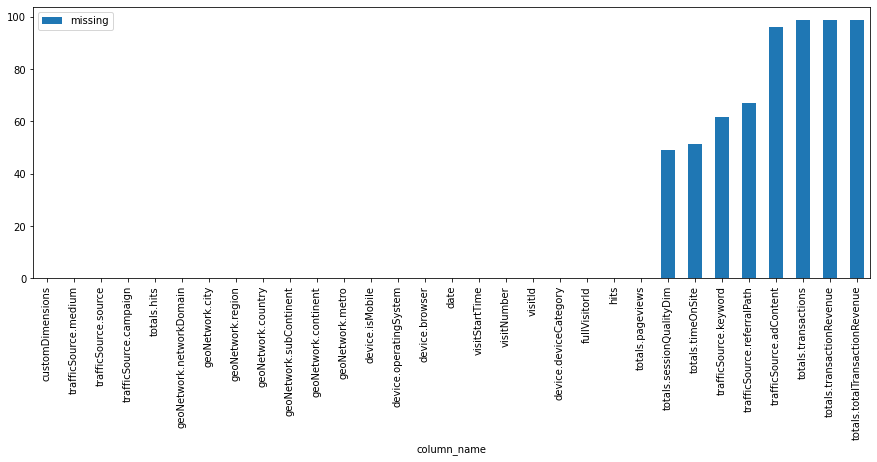

In [23]:
missing_df.sort_values('missing').plot(kind='bar',x='column_name',y='missing',figsize=(15,5))

As we can see there are many fields which have missing values. Some fields have categorical values while some have numerical values.
We will analyse these fields and will try to impute values for fields that contain some useful information

* totals.sessionQualityDim:   

An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range.

In [6]:
train_df.to_pickle('train_df')
test_df.to_pickle('test_df')
train_df=pd.read_pickle('train_df')
test_df=pd.read_pickle('test_df')

In [25]:
# so for all missing values in 'sessionQualityDim' feature we will fill with zeros.

train_df['totals.sessionQualityDim'].fillna(0,inplace=True)
test_df['totals.sessionQualityDim'].fillna(0,inplace=True)

* totals.timeOnSite:             
Total time of the session expressed in seconds

In [26]:
# so for all missing values in 'timeOnSite' feature we will fill with zeros.
train_df['totals.timeOnSite'].fillna(0,inplace=True)
test_df['totals.timeOnSite'].fillna(0,inplace=True)

* trafficSource.keyword:     
    For manual campaign tracking, it is the value of the utm_term campaign tracking parameter. Otherwise, its value is (not set)
   
   utm_term=running+shoes. utm_content. Identifies what specifically was clicked to bring the user to the site, such as a banner ad or a text link. It is often used for A/B testing and content-targeted ads.

In [16]:
print('Number of unique words in trafficSource.keyword',train_df['trafficSource.keyword'].nunique())
print("no.of records having 'nan' are :",train_df['trafficSource.keyword'].astype('str').str.contains('nan').sum(axis=0))
print("no.of records having 'Nan' are :",train_df['trafficSource.keyword'].astype('str').str.contains('Nan').sum(axis=0))
print("no.of records having '(not provided)' are :",train_df['trafficSource.keyword'].astype('str').str.contains('(not provided)').sum(axis=0))


Number of unique words in trafficSource.keyword 348
no.of records having 'nan' are : 69218
no.of records having 'Nan' are : 0
no.of records having '(not provided)' are : 26452


In [37]:
#replacing all the null values with others keyword
train_df['trafficSource.keyword'].replace(['nan','Nan','NAN','(not provided)'],'others',inplace=True)
train_df['trafficSource.keyword'].fillna('others',inplace=True)
test_df['trafficSource.keyword'].replace(['nan','Nan','NAN','(not provided)'],'others',inplace=True)
test_df['trafficSource.keyword'].fillna('others',inplace=True)

In [43]:
train_df['trafficSource.keyword'].isnull().sum(axis=0)
test_df['trafficSource.keyword'].isnull().sum(axis=0)

0

* totals.transactions:              
  Total number of ecommerce transactions within the session., so we will fill nulls with zeros.

In [42]:
train_df['totals.transactions'].fillna(0,inplace=True)
test_df['totals.transactions'].fillna(0,inplace=True)

* trafficSource.referralPath:   
this feature has about 60 %  data present. Which might be helpful in finding some insights into the referral source., we will  consider it as one category while doing label encoding.

In [61]:
train_df['trafficSource.referralPath'].unique()

array([nan,
       '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016',
       '/offer/2145', ..., '/mail/mu/mp/118/', '/BB1QfReObs',
       '/mail/mu/mp/509/'], dtype=object)

In [57]:
train_df.isna().mean()*100

customDimensions                   0.000000
date                               0.000000
fullVisitorId                      0.000000
hits                               0.000000
visitId                            0.000000
visitNumber                        0.000000
visitStartTime                     0.000000
device.browser                     0.000000
device.operatingSystem             0.000000
device.isMobile                    0.000000
device.deviceCategory              0.000000
geoNetwork.continent               0.000000
geoNetwork.subContinent            0.000000
geoNetwork.country                 0.000000
geoNetwork.region                  0.000000
geoNetwork.metro                   0.000000
geoNetwork.city                    0.000000
geoNetwork.networkDomain           0.000000
totals.hits                        0.000000
totals.pageviews                   0.013990
totals.sessionQualityDim           0.000000
totals.timeOnSite                  0.000000
totals.transactions             

In [48]:
train_df['trafficSource.adContent'].unique()

array([nan, 'Placement Accessories 300 x 250', 'Google Merchandise Store',
       'Bags 300x250', 'Display Ad created 3/11/14',
       'Placement Office 300x250', 'Placement Drinkware 300x250',
       'Office Placement 160x600', 'Bags 336x280',
       'test_tyler_hr_merchant', 'Drinkware 336x280',
       'Official Google Merchandise', 'First Full Auto Template Test Ad',
       'Full auto ad IMAGE ONLY', '{KeyWord:Google Brand Items}',
       'Ad from 11/7/16', 'Display Ad created 3/11/15', 'Ad from 11/3/16',
       'Ad from 12/13/16', 'Google Online Store',
       'Google Merchandise Collection', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Smart display ad - 8/17/2017',
       'BQ', 'Placement Accessores 300 x 250',
       'Placement Accessories 336 x 280',
       'Placeme

* trafficSource.adContent:   
this feature has about 95% of missing data ., but 5 % present data seem to be informative regarding ads.,  so all missing data will be considered as one category when we do label encoding.

Note:
* Both totals.transactionRevenue  and transactionRevenue refer the same meaning., but kaggle is using 'tranasactionRevenue' as target feature., google official anlytics document says that 'tranasactionRevenue' was deprecated and suggests to use 'totaltranasactionRevenue' as target feature.
* so for the time being we will follow kaggle provided target variable.

https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/71779    
https://support.google.com/analytics/answer/3437719?hl=en

* totals.totalTransactionRevenue :  
we will impute the missing values with zero

In [56]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)


In [59]:
train_df['hits'][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

In [60]:
train_df['customDimensions'][0]

"[{'index': '4', 'value': 'EMEA'}]"

As we can see customDimensions and hits contain complex values which does not look informative so dropping these columns will not affect out data much

In [62]:
train_df.to_csv('./preprocessed_train_df1.csv')
test_df.to_csv('./preprocessed_test_df1.csv')

In [1]:
# reading from files
import pandas as pd
train_df = pd.read_csv('./preprocessed_train_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = pd.read_csv('./preprocessed_test_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
train_df = train_df.reset_index()
test_df  = test_df.reset_index()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#  Exploratory Data Analysis

##  Distribution of Target Variable(totals.transactionRevenue) in training data set

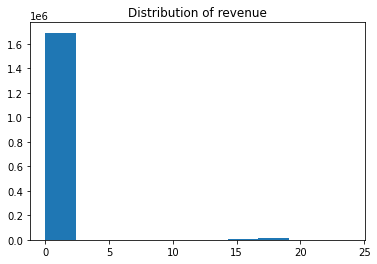

In [9]:
plt.hist(np.log1p(train_df.loc[train_df['totals.transactionRevenue'].isna()==False,'totals.transactionRevenue']))
plt.title('Distribution of revenue');
plt.show()

The plot shows that the revenue for most users is zero which the 80:20 rule infers that 80% revenue is generated by 20% users.   
Only few transactions have non-zero revenue and we will use these for finding useful information.

Let us look at revenue per user

In [11]:
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype('float')
grouped=train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

#plt.scatter()

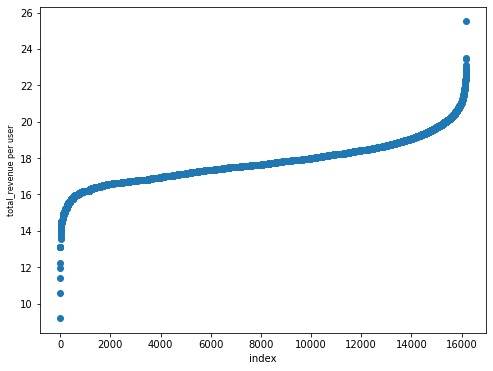

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(x=range(len(grouped.loc[grouped['totals.transactionRevenue']>0,'totals.transactionRevenue'])),y=np.sort(np.log1p(grouped.loc[grouped['totals.transactionRevenue']>0,'totals.transactionRevenue'])))
plt.xlabel('index')
plt.ylabel('total_revenue per user',fontsize=8)            
plt.show()

* non-zero transactions analysis:

In [11]:
non_zero_Revenue_records=0
unique_users_with_non_zero_revenue=set()
for i,j in zip(train_df['totals.transactionRevenue'],train_df['fullVisitorId']):
    if i>0:
        non_zero_Revenue_records += 1
        unique_users_with_non_zero_revenue.add(j)

In [18]:
print('Total records having non zero revenue are {} out of {} which is {}%'.format(non_zero_Revenue_records,len(temp),non_zero_Revenue_records/len(temp)*100))

print("Out of {0} customers only {1} customers are generating revenue and which is about: {2}%" \
      .format(train_df['fullVisitorId'].nunique(),len(unique_users_with_non_zero_revenue),(len(unique_users_with_non_zero_revenue))*100/train_df['fullVisitorId'].nunique()))

Total records having non zero revenue are 18514 out of 1371486 which is 1.3499226386561731%
Out of 1371486 customers only 16584 customers are generating revenue and which is about: 1.2091993647766%


* Common users between train and test

In [23]:
print('Number of common users between train and test sets are:',len(set(train_df['fullVisitorId']).intersection(set(test_df['fullVisitorId']))))

Number of common users between train and test sets are: 2649


# Trend analysis :
* no.of visits over time:    
In our data each record corresponds to one visit.


In [24]:
train_df.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,0.0,0.0,0.0,NaN,(not set),google,organic,water bottle,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,28.0,0.0,0.0,NaN,(not set),sites.google.com,referral,others,/a/google.com/transportation/mtv-services/bike...,NaN


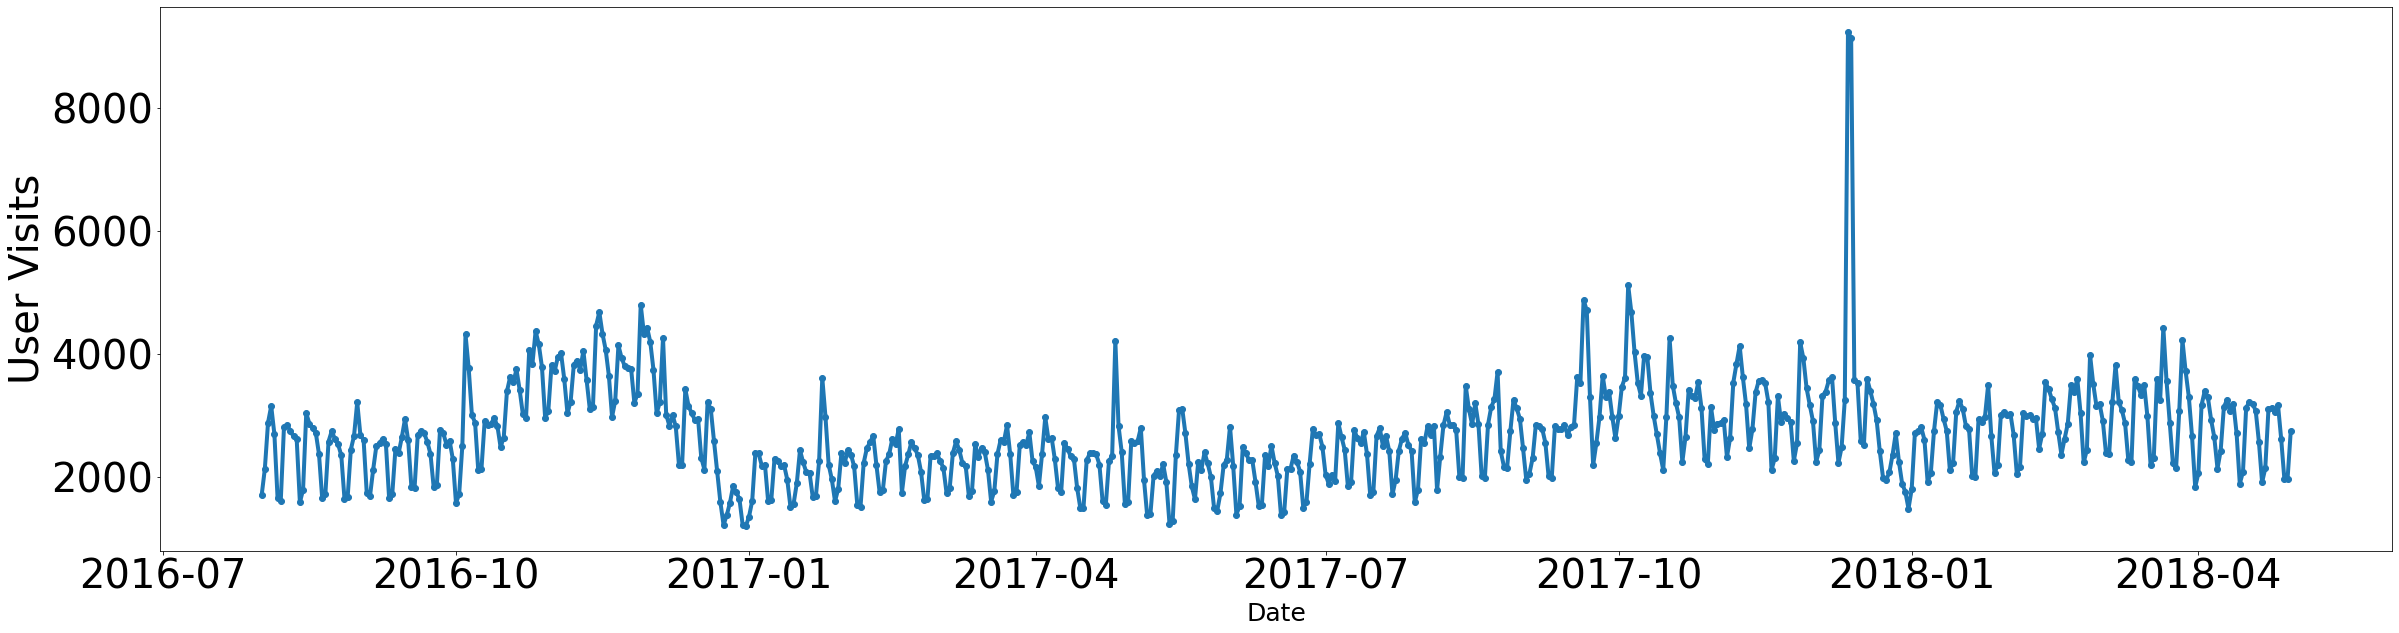

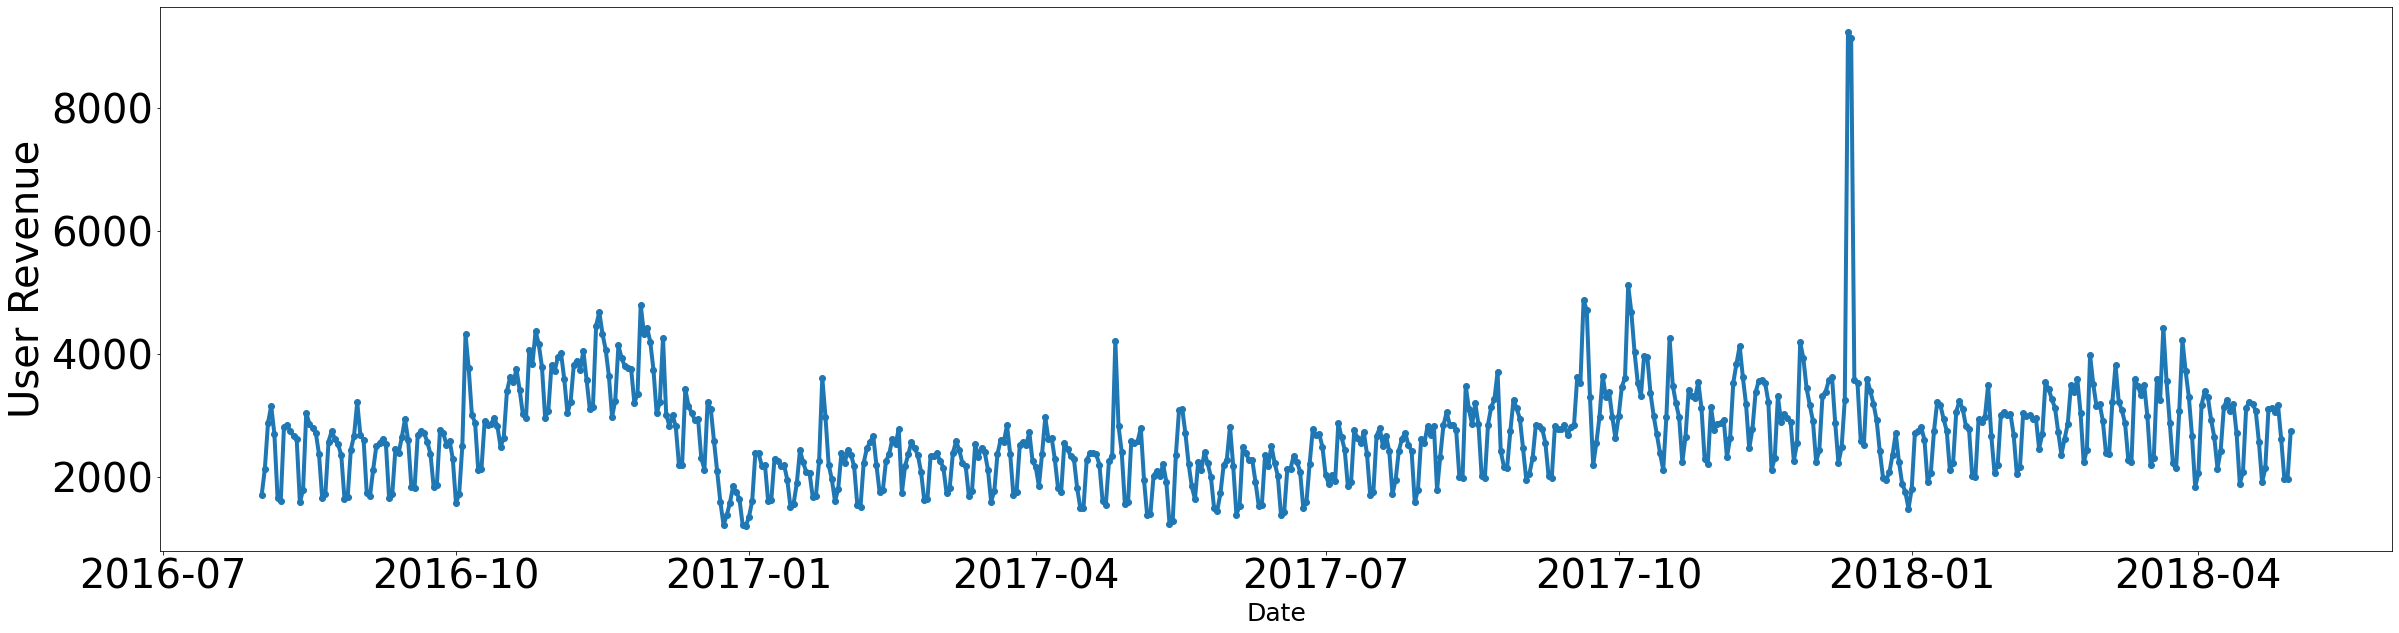

In [34]:
train_df['date']=pd.to_datetime(train_df['date'],infer_datetime_format=True,format='%Y%m%d')
# Compute count of group, excluding missing values(include only non zero values).
df_date_count=train_df.groupby('date').count()
df_date_count.reset_index(inplace=True)

# plot for no.of visits in each date :
plt.figure(figsize=(40,10))
plt.plot_date(x='date',y='fullVisitorId',data=df_date_count,linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('User Visits',fontsize=40)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.autoscale(True)
plt.show()

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x='date',y='totals.transactionRevenue',data=df_date_count,linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('User Revenue',fontsize=40)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.autoscale(True)
plt.show()

* observation:

 * In the months of December-2017 (no.of vists) and revenue are raised drastically.
 * So this is one of the useful insights to the marketing teams., so that they can invest more money in promotions in the month of december

## Channel grouping analysis:

In [36]:
train_df['channelGrouping'].value_counts()

Organic Search    738963
Social            354971
Direct            273134
Referral          211307
Display            51283
Paid Search        45627
Affiliates         32915
(Other)              137
Name: channelGrouping, dtype: int64

In [52]:
temp_1=train_df.groupby('channelGrouping')['fullVisitorId'].count().reset_index()
temp_2=train_df.groupby('channelGrouping')['totals.transactionRevenue'].sum().reset_index() # for each channel we are taking sum of all transactions


In [53]:
temp_2

,channelGrouping,totals.transactionRevenue
0,(Other),9.990000e+06
1,Affiliates,8.650700e+08
2,Direct,5.973243e+11
3,Display,1.082893e+11
4,Organic Search,5.394990e+11
5,Paid Search,6.696862e+10
6,Referral,9.960210e+11
7,Social,7.367770e+09


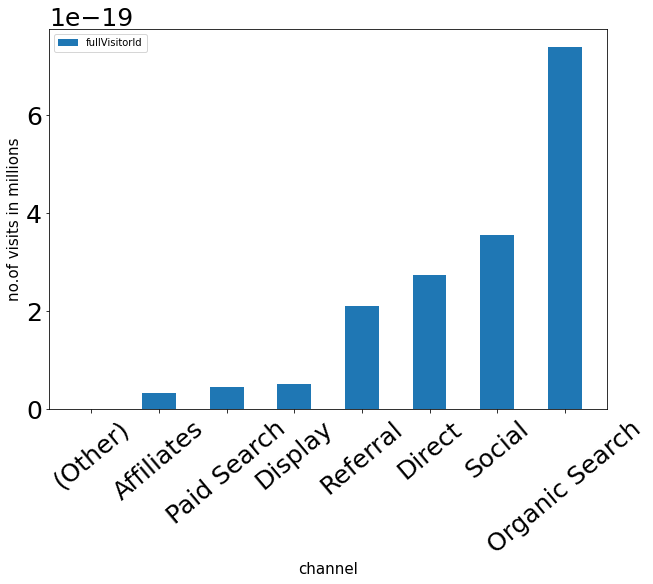

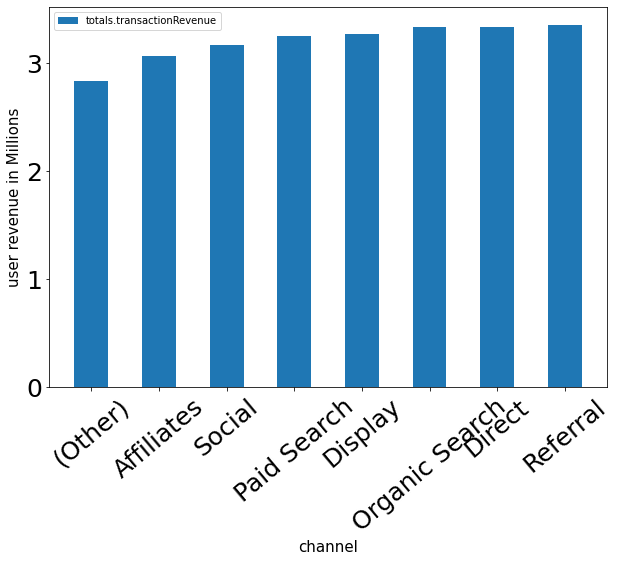

In [57]:
# for no.of visits in each channel plot: 
# --------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**6)
temp_1.sort_values('fullVisitorId').plot(kind='bar',x='channelGrouping',y='fullVisitorId',linestyle='solid',linewidth=4,figsize=(10,7))
plt.autoscale(True)
plt.xticks(rotation=40)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.xlabel('channel', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in millions', fontsize=15) # y- axis label and font size
plt.show()

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue'])
temp_2.sort_values('totals.transactionRevenue').plot(kind='bar',x='channelGrouping',y='totals.transactionRevenue',linestyle='solid',linewidth=4,figsize=(10,7))
plt.autoscale(True)
plt.xticks(rotation=40)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.xlabel('channel', fontsize=15)                         # x- axis label and font size
plt.ylabel('user revenue in Millions', fontsize=15) # y- axis label and font size
plt.show()

* observations:
 * The most revenue is coming from 'organic search', 'Direct','Referral'.., but no.of visits in 'Direct', 'referral' are very less.
 * so here conclusion is that the analytics team can invest less money in 'Direct','referral' channels (since less users are visting from this channel) and can generate more revenue.

* TrafficSource analysis:

In [61]:
train_df['trafficSource.source'].value_counts()

google                  658384
(direct)                565975
youtube.com             329450
analytics.google.com     37436
Partners                 32931
                         ...  
id.pinterest.com             1
images.google.co.in          1
es.pinterest.com             1
mobile.facebook.com          1
google.se                    1
Name: trafficSource.source, Length: 345, dtype: int64

* no.of visits per each traffic source
* total revenue generated per each traffic source
* As there are around 345 different sources  we are only looking at the top 20 here

Text(0, 0.5, 'Transaction Revenue in Millions')

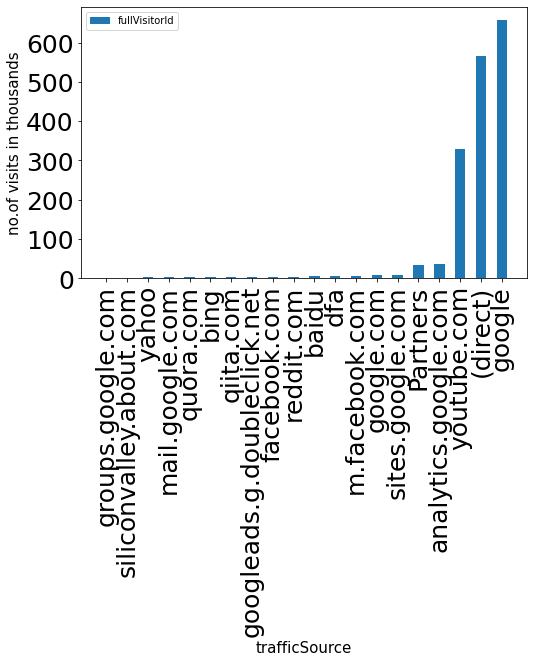

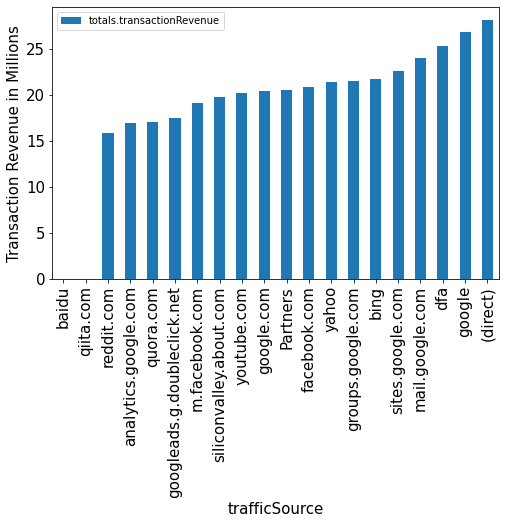

In [62]:
temp_1 = train_df.groupby('trafficSource.source')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("trafficSource.source")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions

    
top_20_traffic_sources = train_df['trafficSource.source'].value_counts()[:20].index.tolist() # list the top 20 browsers
temp_1 = temp_1[temp_1['trafficSource.source'].isin(top_20_traffic_sources)].reset_index()                 # taking only top-20 brosers group
temp_2 = temp_2[temp_2['trafficSource.source'].isin(top_20_traffic_sources)].reset_index()                 #  taking only top-20 brosers group 


# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='trafficSource.source',y='fullVisitorId',figsize=(8,5))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('trafficSource', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='trafficSource.source',y='totals.transactionRevenue',figsize=(8,5))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('trafficSource', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

Direct ,Google ,YouTube are driving more customers and also converting it to revenue..
while some sites like quora, reddit etc., are generating good revenue after very few visits, so this can be improved if the marketing is focused more on these sources.

* Continent analysis:

In [66]:
train_df['geoNetwork.continent'].value_counts()

Americas     877403
Asia         396719
Europe       368037
Africa        35481
Oceania       28180
(not set)      2517
Name: geoNetwork.continent, dtype: int64

Text(0, 0.5, 'Transaction Revenue in Millions')

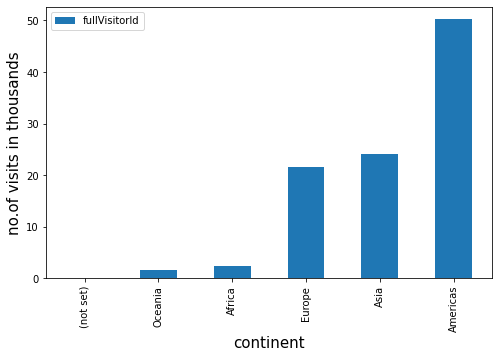

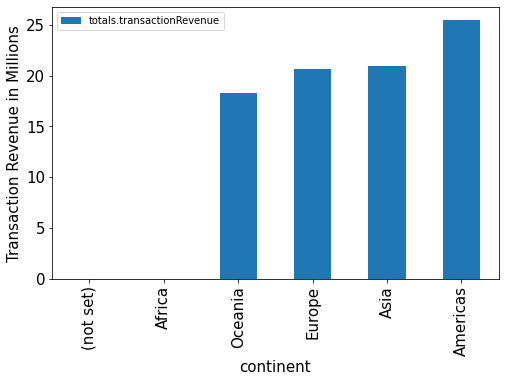

In [22]:
temp_1 = train_df.groupby('geoNetwork.continent')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("geoNetwork.continent")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions



# for no.of visits in each continent plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='geoNetwork.continent',y='fullVisitorId',figsize=(8,5))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('continent', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each continent plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='geoNetwork.continent',y='totals.transactionRevenue',figsize=(8,5))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('continent', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

observation:
no.of visits from america are significantly more as compared to other continents
even no.of visits are less from 'oceania','africa'., but these continents are also generating good amount of revenue. so it is better to invest in this two continent sources

* Mobile vs non-mobile analysis:

In [71]:
train_df['device.isMobile'].value_counts()

False    1171670
True      536667
Name: device.isMobile, dtype: int64

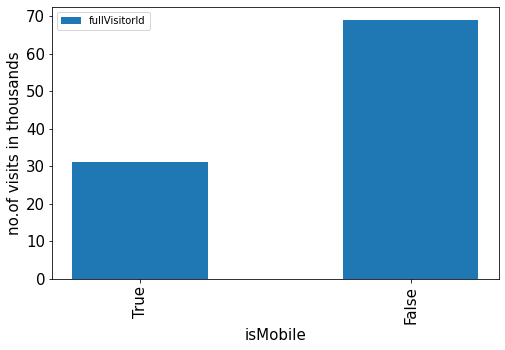

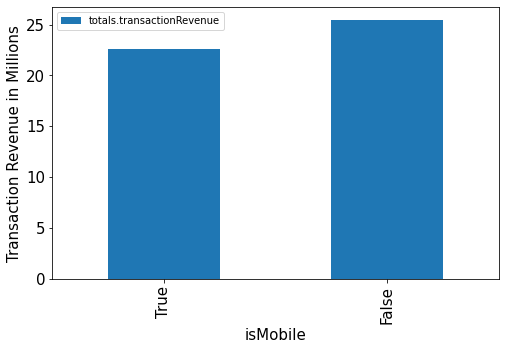

In [23]:
temp_1 = train_df.groupby('device.isMobile')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.isMobile")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions



# for no.of visits in each device.isMobile plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.isMobile',y='fullVisitorId',figsize=(8,5))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('isMobile', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each device.isMobile plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.isMobile',y='totals.transactionRevenue',figsize=(8,5))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('isMobile', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size
plt.show()

* Observations:       
  * Visits of non-mobile users are much higher than the mobiles users.     
  * Mobile users are generating high revenues proportionally , these users can be targeted to genenrate for revenue
    

* Web-browser analysis:

In [73]:
train_df['device.browser'].value_counts()

Chrome                                                  1173056
Safari                                                   312165
Firefox                                                   63845
Internet Explorer                                         35474
Android Webview                                           34266
                                                         ...   
;__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;          1
[Use default User-agent string] LIVRENPOCHE                   1
Hisense M20-M_LTE                                             1
rbydojcflwzvnuaepmsgxhiktq                                    1
User Agent                                                    1
Name: device.browser, Length: 129, dtype: int64

In [75]:
print('No. of unique browsers in our dataset:',train_df['device.browser'].nunique())
print("we are analyzing the top 20 browsers and those are :\n \n",train_df['device.browser'].value_counts()[0:20])

No. of unique browsers in our dataset: 129
we are analyzing the top 20 browsers and those are :
 
 Chrome                      1173056
Safari                       312165
Firefox                       63845
Internet Explorer             35474
Android Webview               34266
Edge                          20543
Samsung Internet              15792
Opera Mini                    15018
Safari (in-app)               14207
Opera                          9585
UC Browser                     5313
YaBrowser                      3045
Amazon Silk                    1467
Coc Coc                        1242
Android Browser                 941
Mozilla Compatible Agent        663
MRCHROME                        308
Maxthon                         287
Puffin                          251
BlackBerry                      243
Name: device.browser, dtype: int64


Text(0, 0.5, 'Transaction Revenue in Millions')

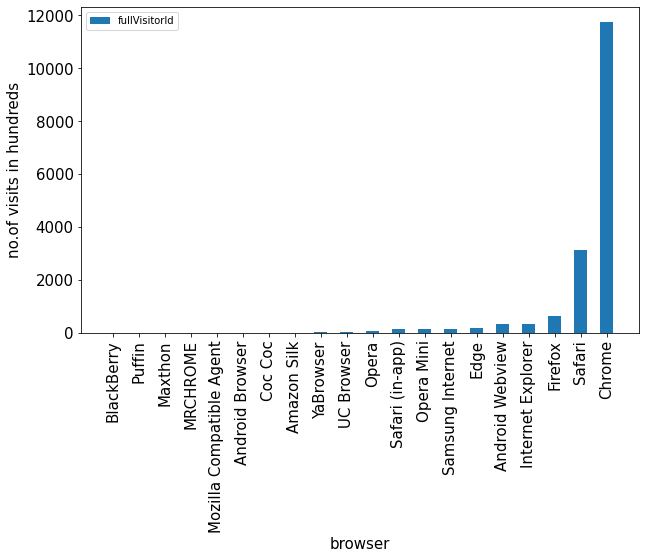

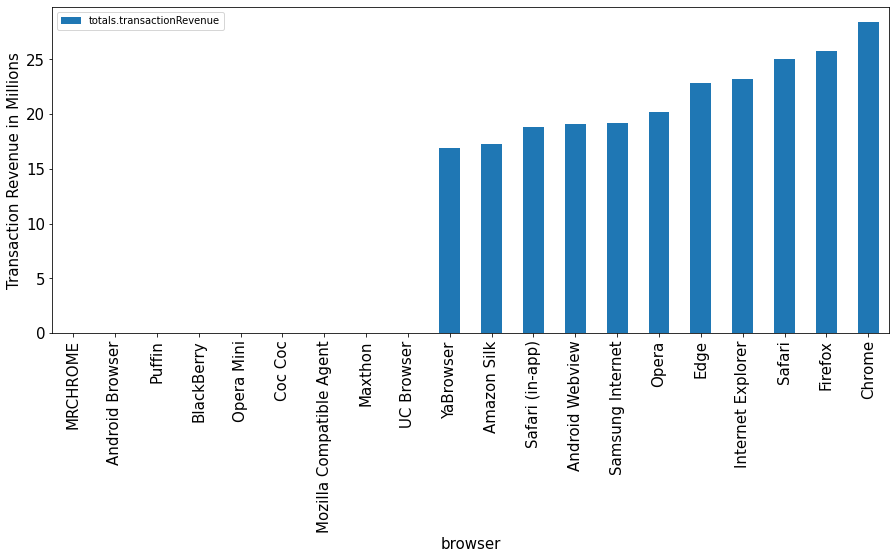

In [76]:
temp_1 = train_df.groupby('device.browser')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.browser")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions

top_20_browsers = train_df['device.browser'].value_counts()[:20].index.tolist() # list the top 20 browsers
temp_1 = temp_1[temp_1['device.browser'].isin(top_20_browsers)].reset_index()                 # taking only top-20 brosers group
temp_2 = temp_2[temp_2['device.browser'].isin(top_20_browsers)].reset_index()                 #  taking only top-20 brosers group 

# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/10**2
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.browser',y='fullVisitorId',figsize=(10,6))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('browser', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in hundreds', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.browser',y='totals.transactionRevenue',figsize=(15,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('browser', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

* Observations:
  * The no.of visits in chrome browser are very huge compared to all other browsers.
  * The most revenue is coming from 'chrome', 'Firefox','safari','Internet explorer','edge','opera','samsung internet','android web view','safari','amazon silk','YaBrowser'..,
  * so here conclusion is the analyitcs team can invest less money on the users visting store through browsers(ex:safari,firefox,opera,edge) except chrome and can generate most revenue.

* OperatingSystem analysis:

In [78]:
train_df['device.operatingSystem'].nunique()
train_df['device.operatingSystem'].value_counts()

Windows             619720
Macintosh           438514
Android             299386
iOS                 219334
Linux                63971
Chrome OS            51318
(not set)            11815
Windows Phone         1675
Samsung                911
Tizen                  709
BlackBerry             350
OS/2                   199
Xbox                   133
Nintendo Wii           100
Firefox OS              97
Nintendo WiiU           51
FreeBSD                 18
Playstation Vita        15
Nintendo 3DS             9
OpenBSD                  3
SunOS                    3
Nokia                    3
SymbianOS                2
NTT DoCoMo               1
Name: device.operatingSystem, dtype: int64

Text(0, 0.5, 'Transaction Revenue in Millions')

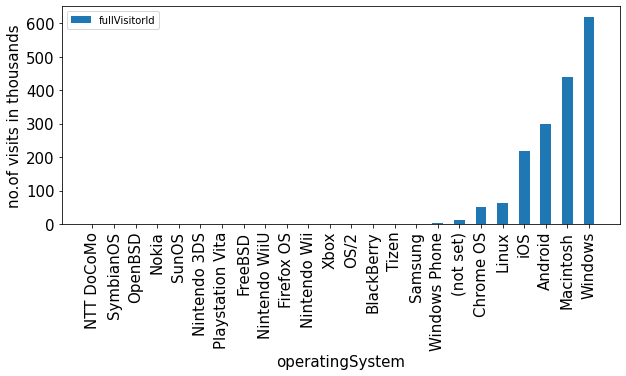

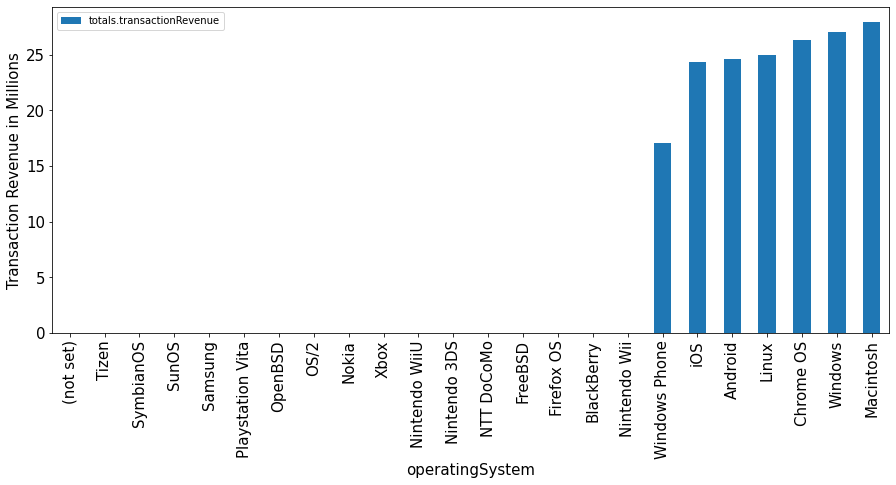

In [79]:
temp_1 = train_df.groupby('device.operatingSystem')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.operatingSystem")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions


# for no.of visits in each operatingSystem plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.operatingSystem',y='fullVisitorId',figsize=(10,4))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('operatingSystem', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each operatingSystem plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.operatingSystem',y='totals.transactionRevenue',figsize=(15,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('operatingSystem', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

* Observations:
  * Most of the users are vsiting through Windows,macintosh and the most revenue is generated from windows and macintosh
  * If we observe carefully very less people (less than 100K) are visting through linux and chrome os., so business team can invest very less on money for promotions on this two os platforms and can generate most revenue.
  * Very importantly through windows phone less than 2000 people are visitng merchandise site but they are also generatng good amout of revenue. so analytics team can invest less money on the windows phone os and can generate good revenue.

* DeviceCategory analysis:

Text(0, 0.5, 'Transaction Revenue in Millions')

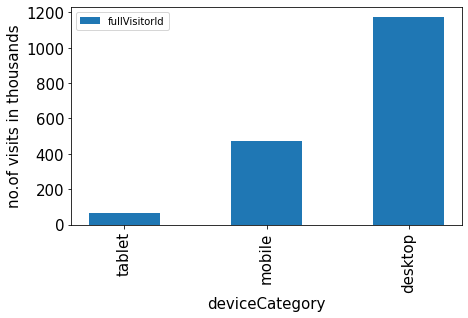

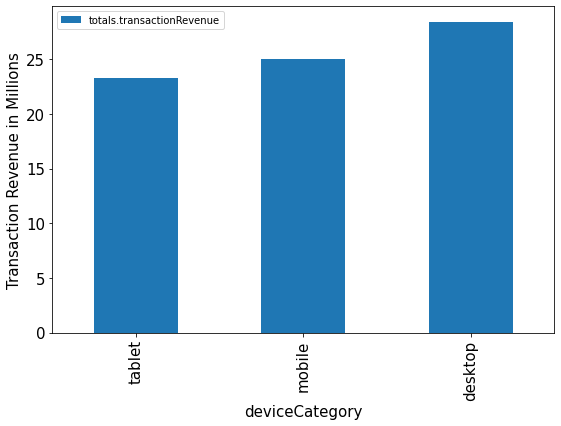

In [80]:
temp_1 = train_df.groupby('device.deviceCategory')['fullVisitorId'].count().reset_index() # counting no.of transactions in each group.

temp_2 = train_df.groupby("device.deviceCategory")["totals.transactionRevenue"].sum().reset_index() # for each channel we are taking
                                                                                            # sum of all transactions


# for no.of visits in each device category plot: 
# ---------------------------------------------

temp_1['fullVisitorId'] = (temp_1['fullVisitorId'])/(10**3)
temp_1.sort_values("fullVisitorId").plot(kind='bar',x='device.deviceCategory',y='fullVisitorId',figsize=(7,4))
plt.autoscale(True)
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('deviceCategory', fontsize=15)                         # x- axis label and font size
plt.ylabel('no.of visits in thousands', fontsize=15) # y- axis label and font size


# for revenue in each device category plot: 
# ---------------------------------------

temp_2['totals.transactionRevenue'] = np.log1p(temp_2['totals.transactionRevenue']) # log(1 + revenue)

temp_2.sort_values("totals.transactionRevenue").plot(kind='bar',x='device.deviceCategory',y='totals.transactionRevenue',figsize=(9,6))
plt.xticks(rotation=90)       # x- axis value names will rotate in 90 degrees
plt.rc('xtick', labelsize=15) # x- axis value's font size
plt.rc('ytick', labelsize=15) # y- axis value's font size

plt.xlabel('deviceCategory', fontsize=15)                         # x- axis label and font size
plt.ylabel('Transaction Revenue in Millions', fontsize=15) # y- axis label and font size

* Observation:
  * Most of the users are vsiting through desktop
  * Here the very important observation is through tablet device less than 68K people(this is significantly less compare with other devices) are visiting but they are generating significantly higher revenue.
  * The analytics team can invest less amount of money for promotions on the users visting store through 'tablet device' and can generate signifincatly higher revenue

# Distribution of hits

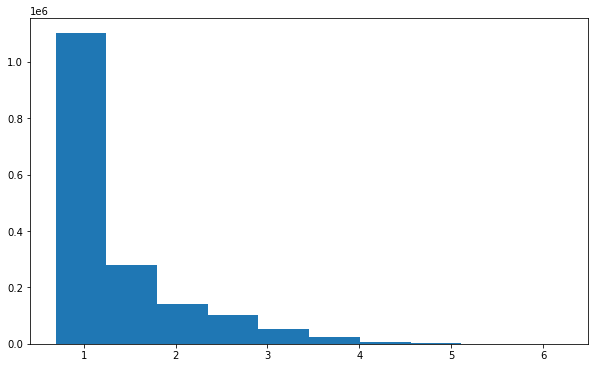

In [22]:
plt.figure(figsize=(10,6))
plt.hist(np.log1p(train_df['totals.hits']))
plt.show()

# Distribution of pageviews

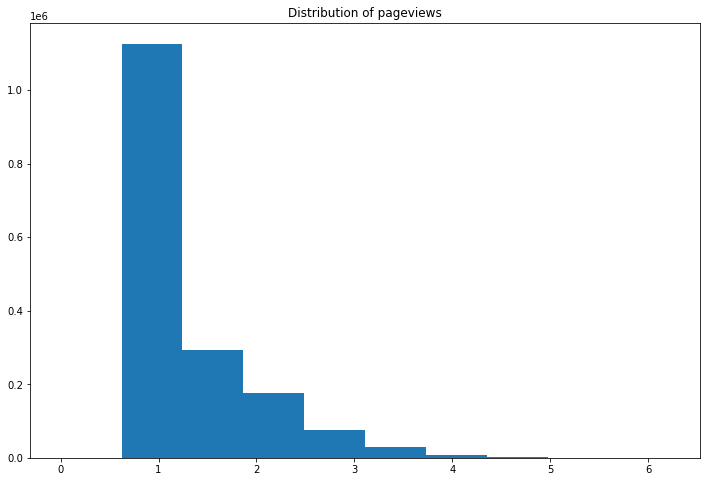

In [24]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of pageviews');
plt.hist(np.log1p(train_df['totals.pageviews'].fillna(0)));

# pageviews vs revenue

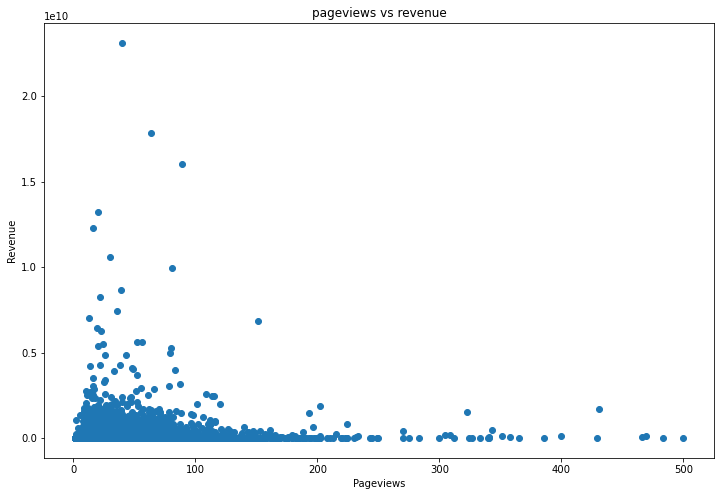

In [23]:
plt.figure(figsize=(12, 8))
plt.title('pageviews vs revenue');
plt.scatter(train_df['totals.pageviews'], train_df['totals.transactionRevenue']);
plt.xlabel('Pageviews');
plt.ylabel('Revenue');

# Correlation

In [29]:
train_df.corr()['totals.transactionRevenue']

visitId                          -0.006830
visitNumber                       0.054580
visitStartTime                   -0.006830
device.isMobile                  -0.017856
totals.hits                       0.145105
totals.pageviews                  0.145350
totals.sessionQualityDim          0.090877
totals.timeOnSite                 0.101785
totals.transactions               0.278610
totals.transactionRevenue         1.000000
totals.totalTransactionRevenue    0.876317
Name: totals.transactionRevenue, dtype: float64

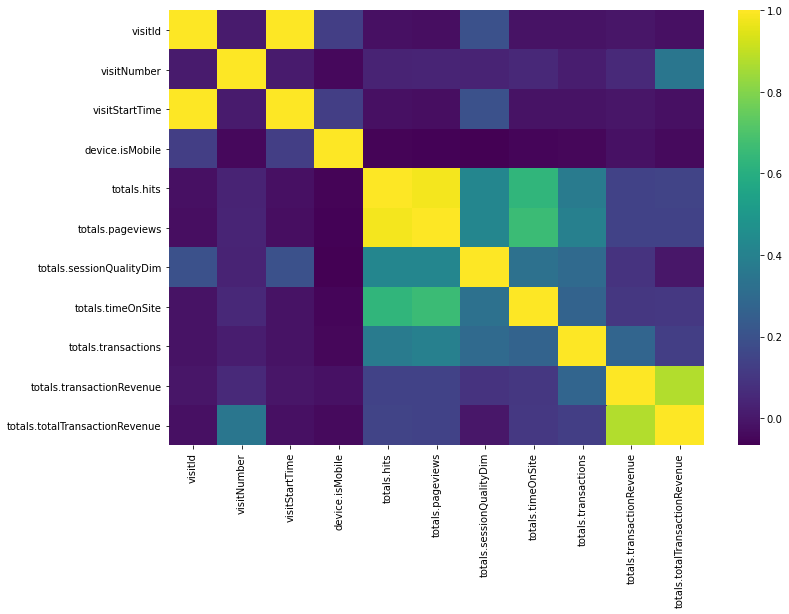

In [28]:
plt.figure(figsize=(12, 8))
import seaborn as sns
sns.heatmap(train_df.corr(),cmap='viridis',fmt='.2g')
plt.show()

In [2]:
# reading from files
import pandas as pd
%time
train_df = pd.read_csv('./preprocessed_train_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
train_df = train_df.reset_index()


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [3]:
test_df = pd.read_csv('./preprocessed_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [4]:
test_df  = test_df.reset_index()

# 3. Featurization 

In [5]:
test_df.fullVisitorId.nunique()

296530

In [6]:
train_df['totals.totalTransactionRevenue'].fillna(0,inplace=True)
test_df['totals.totalTransactionRevenue'].fillna(0,inplace=True)

In [7]:
train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,0.0,0.0,0.0,0.0,(not set),google,organic,water bottle,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,28.0,0.0,0.0,0.0,(not set),sites.google.com,referral,others,/a/google.com/transportation/mtv-services/bike...,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,38.0,0.0,0.0,0.0,(not set),(direct),(none),others,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,1.0,0.0,0.0,0.0,(not set),google,organic,others,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,52.0,0.0,0.0,0.0,(not set),google,organic,others,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,[],2017-01-04,5123779100307500332,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1483554750,1,1483554750,Chrome,Windows,...,626.0,0.0,0.0,0.0,(not set),youtube.com,referral,others,/yt/about/,NaN
1708333,Social,[],2017-01-04,7231728964973959842,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",1483543798,1,1483543798,Chrome,Android,...,258.0,0.0,0.0,0.0,(not set),youtube.com,referral,others,/yt/about/,NaN
1708334,Social,[],2017-01-04,5744576632396406899,"[{'hitNumber': '1', 'time': '0', 'hour': '2', ...",1483526434,1,1483526434,Android Webview,Android,...,991.0,0.0,0.0,0.0,(not set),youtube.com,referral,others,/yt/about/ko/,NaN
1708335,Social,"[{'index': '4', 'value': 'APAC'}]",2017-01-04,2709355455991750775,"[{'hitNumber': '2', 'time': '0', 'hour': '21',...",1483592857,1,1483592864,Chrome,Windows,...,1274.0,0.0,0.0,0.0,(not set),facebook.com,referral,others,/l.php,NaN


In [8]:
test_df.shape

(401589, 31)

# Convert Boolean Features

In [9]:
train_df['device.isMobile']=train_df['device.isMobile'].astype('bool')
test_df['device.isMobile']=test_df['device.isMobile'].astype('bool')

# Convert Numerical Features to Float

In [10]:
#convert the numerical variables to float
num_cols=['visitId','visitStartTime','totals.hits','visitNumber','totals.hits','totals.timeOnSite','totals.transactions',"totals.pageviews", 'totals.totalTransactionRevenue']
for col in num_cols:
    train_df[col]=train_df[col].astype('float')
    test_df[col]=test_df[col].astype('float')

# Label Encode Categorical Features

In [11]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
# label encode the categorical variables and 
cat_cols =  ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory',\
'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country','geoNetwork.region','geoNetwork.metro',\
'geoNetwork.city','geoNetwork.networkDomain','totals.sessionQualityDim','trafficSource.campaign']

for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))     
           

channelGrouping
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
totals.sessionQualityDim
trafficSource.campaign


In [12]:
# storing part1 label encoded data into fields :

train_df.to_csv('./labelencoded_train_df_1.csv')
test_df.to_csv('./labelencoded_test_df_1.csv')

In [4]:
import pandas as pd
%time
train_df = pd.read_csv('./labelencoded_train_df_1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
train_df = train_df.reset_index()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.9 µs


In [5]:
import pandas as pd
%time
test_df = pd.read_csv('./labelencoded_test_df_1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = test_df.reset_index()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


In [6]:
test_df.fullVisitorId.nunique()

296530

In [34]:
train_df['trafficSource.medium'].value_counts()

5    591783
0    565957
6    432963
3     75603
2     32915
4      8982
1       134
Name: trafficSource.medium, dtype: int64

In [8]:
train_df['trafficSource.medium']=train_df['trafficSource.medium'].astype('str').str.replace('(none)','(not set)')
test_df['trafficSource.medium']=test_df['trafficSource.medium'].astype('str').str.replace('(none)','(not set)')

In [9]:
from sklearn.preprocessing import LabelEncoder
col='trafficSource.medium'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

# Creating new columns from source and referralpath

* Binary column if trafficSource has the word "google" in it
* Binary column if trafficSource has the word ".com" in it
* Binary column if referralPath has the word "google" in it
* Binary column if the referralPath has the word "youtube" in it
* Binary column if the referralPath has the word "intl" in it
* Binary column if the referralPath has the word "html" in it

In [10]:
train_df['source_com_or_not']=train_df['trafficSource.source'].astype(str).apply(lambda x: 1 if '.com' in x else 0)
train_df['source_google_or_not']=train_df['trafficSource.source'].astype(str).apply(lambda x: 1 if 'google' in x.split() else 0)
train_df['referralPath_youtube_or_not']=train_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'youtube' in x else 0)
train_df['referralPath_intl_or_nor']=train_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'intl' in x else 0)
train_df['referralPath_html_or_not']=train_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'html' in x else 0)
train_df['referralPath_google_or_not']=train_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'google' in x else 0)


test_df['source_com_or_not']=test_df['trafficSource.source'].astype(str).apply(lambda x: 1 if '.com' in x.split() else 0)
test_df['source_google_or_not']=test_df['trafficSource.source'].astype(str).apply(lambda x: 1 if 'google' in x else 0)
test_df['referralPath_youtube_or_not']=test_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'youtube' in x else 0)
test_df['referralPath_intl_or_nor']=test_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'intl' in x else 0)
test_df['referralPath_html_or_not']=test_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'html' in x else 0)
test_df['referralPath_google_or_not']=test_df['trafficSource.referralPath'].astype(str).apply(lambda x: 1 if 'google' in x else 0)


In [11]:
train_df['trafficSource.source'].value_counts()

google                  658384
(direct)                565975
youtube.com             329450
analytics.google.com     37436
Partners                 32931
                         ...  
cz.pinterest.com             1
lmgtfy.com                   1
m.wikihow.com                1
google.ro                    1
in.pinterest.com             1
Name: trafficSource.source, Length: 345, dtype: int64

In [13]:
col='trafficSource.source'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

In [14]:
train_df['trafficSource.adContent'].value_counts()

Google Merchandise Store          39566
Google Merchandise Collection      6762
Placement Accessores 300 x 250     3040
Smart display ad - 8/17/2017       2664
Display Ad created 3/11/14         2344
                                  ...  
Free Shipping!                        2
Men's Apparel from Google             1
Google Apparel                        1
GA Help Center                        1
Swag w/ Google Logos                  1
Name: trafficSource.adContent, Length: 76, dtype: int64

In [37]:
col='trafficSource.adContent'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

## Cleaning referralPath column
trafficSource.referralPath column has around 3k unique values ,encoding it with LabelEncoder takes a lot of time and ram so we clean the values and remove unnecessary ones. Here we are converting "//' to single "/" and removing any digit or any special character and doing text preprocessing and basic cleaning



In [ ]:
train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].astype('str')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].astype('str')

train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.replace(r'//','/')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.replace(r'//','/')


train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.replace('-','')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.replace('-','')

train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.replace(r'\d+','')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.replace(r'\d+','')

train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.lower()
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.lower()


train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.replace(r'/yt/about/w+?','/yt/about/')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.replace(r'/yt/about/w+?','/yt/about/')


train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)) #removing special symbols
train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].str.replace(r'\s+',' ')
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)) #removing special symbols
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].str.replace(r'\s+',' ')
train_df['trafficSource.referralPath']=train_df['trafficSource.referralPath'].apply(lambda x:x.strip())
test_df['trafficSource.referralPath']=test_df['trafficSource.referralPath'].apply(lambda x:x.strip())



In [43]:
train_df['trafficSource.referralPath'].value_counts()

nan                                           1142073
                                               138309
yt about                                        79164
analytics web                                   33112
yt about es                                     19831
                                               ...   
intl it all yt advertise talktous                   1
yt lineups engb italy html                          1
hangouts vflnbfgsffyvlhzcwflrthue                   1
intl ja yt space losangeles                         1
applications notes current dadk index html          1
Name: trafficSource.referralPath, Length: 2785, dtype: int64

In [46]:
col='trafficSource.referralPath'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

In [ ]:
train_df['trafficSource.referralPath.len']=train_df['trafficSource.referralPath'].str.split(' ').str.len() #word len for referralPath
test_df['trafficSource.referralPath.len']=test_df['trafficSource.referralPath'].str.split(' ').str.len() #word len for referralPath

## Cleaning keyword column
trafficSource.keyword columns also has 3000+ unique values. It also crashed while encoding using LabelEncoder or OneHotEncoder. When checking the trafficSource.keyword values I observed that there were many values misspelled or jumbled up like youtube was present in 30+ ways. I have done basic preprocessing and cleaning

In [ ]:
#creating copies of data
test_df2=test_df.copy()
train_df2=train_df.copy()


In [33]:
from sklearn.preprocessing import LabelEncoder
col='trafficSource.keyword'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

In [15]:
train_df['trafficSource.keyword'].value_counts()[:50]

others                                                                                 1621713
(User vertical targeting)                                                                25918
(automatic matching)                                                                     18464
6qEhsCssdK0z36ri                                                                         10870
(Remarketing/Content targeting)                                                           5826
1hZbAqLCbjwfgOH7                                                                          2990
google merchandise store                                                                  2612
Google Merchandise                                                                        1879
1X4Me6ZKNV0zg-jV                                                                          1277
google store                                                                              1148
DoubleClick Ad Exchange                           

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
 phrase = re.sub(r"won't", "will not", phrase)
 phrase = re.sub(r"can\'t", "can not", phrase)
 # general
 phrase = re.sub(r"n\'t", " not", phrase)
 phrase = re.sub(r"\'re", " are", phrase)
 phrase = re.sub(r"\'s", " is", phrase)
 phrase = re.sub(r"\'d", " would", phrase)
 phrase = re.sub(r"\'ll", " will", phrase)
 phrase = re.sub(r"\'t", " not", phrase)
 phrase = re.sub(r"\'ve", " have", phrase)
 phrase = re.sub(r"\'m", " am", phrase)
 return phrase
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
import re
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].astype('str')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)) #removing special symbols
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace(r'\s+',' ') #replacing multispaces with a single space
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:x.strip()) #removing leading/trailing spaces 
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:x.lower()) #to lowercase                                                                          
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x: re.sub(r'\d+', ' ', x)) #removing digits
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:" ".join(set(str(x).split())))
                                                                          #removing duplicated values                                                                          
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('t shirt','tshirt').replace('tshirts','tshirt')\
.replace('you tube','youtube').replace('yotube','youtube').replace('yutube','youtube').replace('ytube','youtube').replace('youtub','youtube').str.replace('u tube','youtube') 
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('www','online')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('https','online')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('com','online')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('hzbaqlcbjwfgoh','others')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('qehscssdk ri','others')        

train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('jv zg zknv me','others')
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace('qehscssdk ri','others')                                  

In [ ]:
import re
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].astype('str')
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x)) #removing special symbols
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace(r'\s+',' ') #replacing multispaces with a single space
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:x.strip()) #removing leading/trailing spaces 
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:x.lower()) #to lowercase                                                                          
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x: re.sub(r'\d+', ' ', x)) #removing digits
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:" ".join(set(str(x).split())))
                                                                          #removing duplicated values                                                                          
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('t shirt','tshirt').replace('tshirts','tshirt').str.replace('shirt t','tshirt')\
.replace('you tube','youtube').replace('yotube','youtube').replace('yutube','youtube').replace('ytube','youtube').replace('youtub','youtube').str.replace('u tube','youtube') 
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('www','online')
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('https','online')
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('com','online')
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('not set','others')
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace('shirt google t','google tshirt')                                 

In [ ]:
for i in u_tube:
    train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace(i,'youtube')
    test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace(i,'youtube')


for i in m_dise:
    train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace(i,'youtube')
    test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace(i,'youtube')
    
    
for i in g_oogle:
    train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].str.replace(i,'youtube')
    test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].str.replace(i,'youtube')    


In [40]:
#removing stopwords from train and test
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:" ".join(str(x) for x in x.split() if x not in stopwords) )
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:" ".join(str(x) for x in x.split() if x not in stopwords) )                                                                     

#removing words with len =1
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:" ".join(str(x) for x in x.split() if len(x)>1))
train_df['trafficSource.keyword']=train_df['trafficSource.keyword'].apply(lambda x:" ".join(set(str(x).split())))     

test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:" ".join(str(x) for x in x.split() if len(x)>1))
test_df['trafficSource.keyword']=test_df['trafficSource.keyword'].apply(lambda x:" ".join(set(str(x).split())))   

In [27]:
#top keywords with values>20

train_df['trafficSource.keyword'].value_counts()[0:50]

nan                                                    1346974
provided not                                            190785
not set                                                 158519
youtube merch                                             3387
merchandise store google                                  2628
merchandise youtube                                       1689
merchandise google                                         592
matching automatic                                         469
backpack youtube                                           312
apparel google                                             283
merchandise store youtube                                  228
online online youtubemerchandisestore online               220
swag google                                                179
clothing google                                            127
store youtube merch                                        110
youtubemerchandisestore                                

In [41]:
from sklearn.preprocessing import LabelEncoder
col='trafficSource.keyword'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

# WordCloud for keyword column

In [207]:
# count each dish to see how many times each dish repeated
keyword_count = []
for i in train_df['trafficSource.keyword']: ## iterate in each rows in table
    for t in i.split(','):
        t = t.strip() # remove the white spaces to get accurate results
        keyword_count.append(t)

In [100]:
# count each dish to see how many times each dish repeated
keyword_count_test = []
for i in test_df1['trafficSource.keyword']: ## iterate in each rows in table
    for t in i.split(','):
        t = t.strip() # remove the white spaces to get accurate results
        keyword_count_test.append(t)

In [98]:
!pip install wordcloud

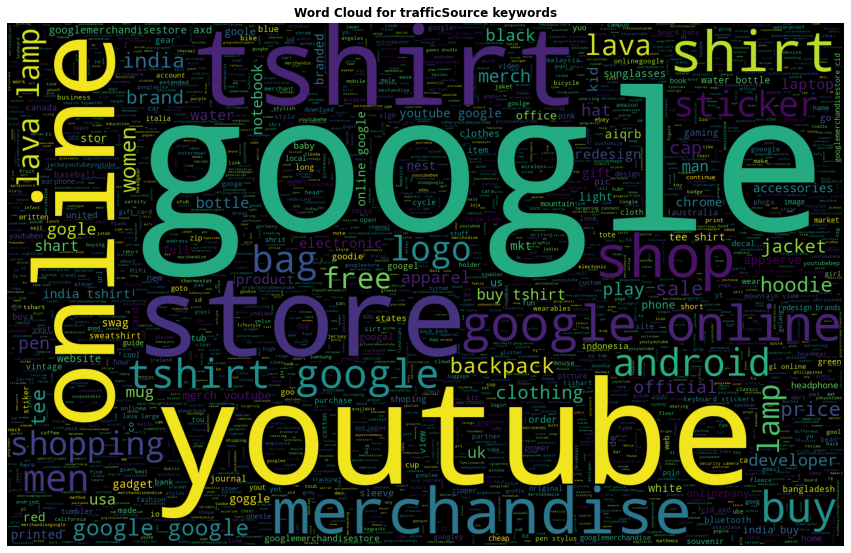

In [208]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
keyword_set = set(keyword_count)
keyword_word_cloud = ', '.join(keyword_set)

plt.figure( figsize=(15,10) )
wc = WordCloud(width=1600, height=1000,background_color="black", max_words=len(keyword_word_cloud))
wc.generate(keyword_word_cloud)
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for trafficSource keywords',weight='bold')
plt.axis("off")
plt.imshow(wc)
plt.show()

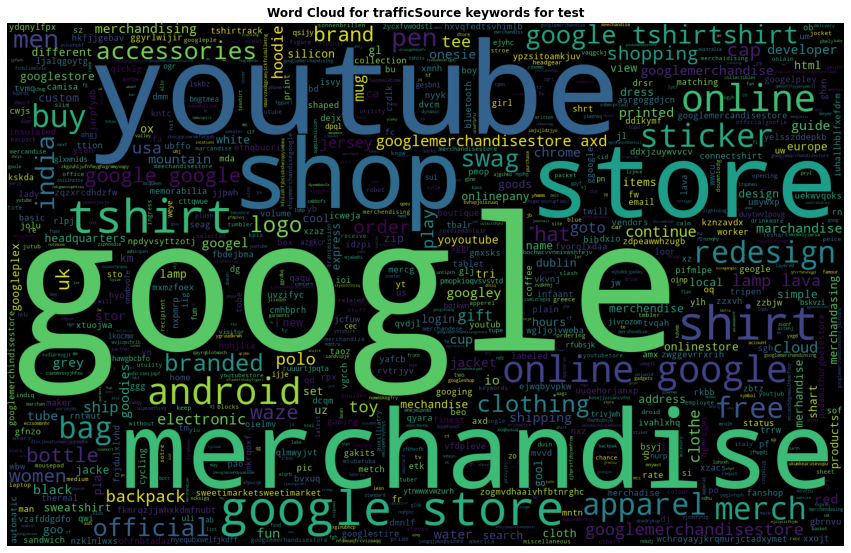

In [102]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
keyword_set = set(keyword_count_test)
keyword_word_cloud = ', '.join(keyword_set)

plt.figure( figsize=(15,10) )
wc = WordCloud(width=1600, height=1000,background_color="black", max_words=len(keyword_word_cloud))
wc.generate(keyword_word_cloud)
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for trafficSource keywords for test',weight='bold')
plt.axis("off")
plt.imshow(wc)
plt.show()

In [ ]:
train_df = pd.read_csv('./labelencoded_train_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = pd.read_csv('./labelencoded_test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [53]:
# storing all label encoded data into fiels:

train_df.to_csv('./labelencoded_train_df_final.csv')
test_df.to_csv('./labelencoded_test_df_final.csv')

In [16]:
%%time
import pandas as pd
train_df = pd.read_csv('./labelencoded_train_df_final.csv',dtype={'fullVisitorId': 'str'},index_col=0)


/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 2min 48s, sys: 25.1 s, total: 3min 13s
Wall time: 5min 43s


In [17]:
%%time
test_df  =pd.read_csv('./labelencoded_test_df_final.csv',dtype={'fullVisitorId': 'str'})

test_df  = test_df.reset_index()

CPU times: user 968 ms, sys: 88 ms, total: 1.06 s
Wall time: 1.28 s


In [18]:
test_df.fullVisitorId.nunique()

296530

In [50]:
test_df.drop(['customDimensions','hits'],axis=1,inplace=True)


In [48]:
from sklearn.preprocessing import LabelEncoder
col='device.isMobile'
lbl = LabelEncoder()
lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))    

In [9]:
train_df.columns

Index(['level_0', 'index', 'channelGrouping', 'customDimensions', 'date',
       'fullVisitorId', 'hits', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.operatingSystem', 'device.isMobile',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'source_com_or_not', 'source_google_or_not',
       'referralPath_youtube_or_not', 'referralPath_intl_or_nor',
       'referralPath_html_or_not', 'referralPath_google_or_not',
       'trafficSource.referra

# Featurization of Train Data

In [6]:
train_df1=train_df
test_df1=test_df

In [7]:
# In our given data the data field is in string format., so we are converting it into normal date format:

train_df1["date"] = pd.to_datetime(train_df1["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
test_df1["date"]  = pd.to_datetime(test_df1["date"], infer_datetime_format=True, format="%Y%m%d")

In [12]:
test_df1

,index,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,source_com_or_not,source_google_or_not,referralPath_youtube_or_not,referralPath_intl_or_nor,referralPath_html_or_not,referralPath_google_or_not,trafficSource.referralPath.len
0,0,4,2018-05-11,7460955084541987166,1.526099e+09,2.0,1.526099e+09,55,1,1,...,340,2044,0,0,1,0,0,0,0,2
1,1,2,2018-05-11,460252456180441002,1.526064e+09,166.0,1.526064e+09,55,7,0,...,368,2044,0,0,0,0,0,0,0,2
2,2,4,2018-05-11,3461808543879602873,1.526067e+09,2.0,1.526067e+09,55,3,0,...,340,2044,0,0,1,0,0,0,0,2
3,3,2,2018-05-11,975129477712150630,1.526108e+09,4.0,1.526108e+09,55,25,1,...,368,2044,0,0,0,0,0,0,0,2
4,4,4,2018-05-11,8381672768065729990,1.526060e+09,1.0,1.526060e+09,71,22,1,...,340,2044,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,401584,4,2018-09-07,6701149525099562370,1.536354e+09,1.0,1.536354e+09,55,1,1,...,340,2044,0,0,1,0,0,0,0,2
401585,401585,4,2018-09-07,6154541330147351453,1.536388e+09,1.0,1.536388e+09,55,22,0,...,340,2044,0,0,1,0,0,0,0,2
401586,401586,4,2018-09-07,6013469762773705448,1.536352e+09,3.0,1.536352e+09,64,22,0,...,340,2044,0,0,1,0,0,0,0,2
401587,401587,4,2018-09-07,4565378823441900999,1.536340e+09,1.0,1.536340e+09,55,3,0,...,340,2044,0,0,1,0,0,0,0,2


In [13]:
# In our given data the data field is in string format., so we are converting it into normal date format:

train_df1["date"] = pd.to_datetime(train_df1["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
test_df1["date"]  = pd.to_datetime(test_df1["date"], infer_datetime_format=True, format="%Y%m%d")
from datetime import timedelta
import numpy as np
def getTimeFramewithFeatures(data,k):
    
    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) 
                           & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]
    
    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
      #in code k=1 and min(data['date']) = aug 1st 2016
       # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)
    
    
    
    
    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) 
                    & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]
    
    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
      #in code max(train_frame_k['date'])=jan 15th 2017
       # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"
    
    

    
    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection
    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction
    
    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period. 
    # Here cooling period means(=46 days) from "train_frame" end date
    #so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.
    
    
    
    # preparing returned customers data:
    # ----------------------------------
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]  
    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    returned_customers_transactions['is_returned'] = 1
    returned_customers_transactions.rename(columns={'totals.transactionRevenue': 'revenue'}, inplace=True) 
    
    
    
    
    # preparing non-returned customers data:
    # ----------------------------------
    
    non_returned_customers_data                  = pd.DataFrame()
    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))
    non_returned_customers_data['is_returned']   = 0
    non_returned_customers_data['revenue']       = 0
    
    
    # so final time based featurizations(for classification model):
    #--------------------------------------------------------------------
    # we are concatinating returned and non-returned users 
    
    classification_features = pd.concat([returned_customers_transactions, non_returned_customers_data], axis=0)\
                              .reset_index(drop=True)
    
    
   
    
    # featurization for train_frame_k data :
    # ------------------------------------------
    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation
    
    train_frame_k_maxdate = max(train_frame_k['date'])
    train_frame_k_mindate = min(train_frame_k['date'])
    
    train_frame_k = train_frame_k.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
        #'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - train_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    train_frame_k.columns = train_frame_k.columns.droplevel() 
    
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_frame_k = pd.merge(train_frame_k, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_frame_k

In [14]:
train_test_data = pd.concat([train_df1, test_df1], axis=0).reset_index()

In [25]:
%%time
train_frame_1 = getTimeFramewithFeatures(train_test_data,1)  
train_frame_1.to_pickle('train_frame_1')

CPU times: user 46min 29s, sys: 38.3 s, total: 47min 8s
Wall time: 45min 52s


In [26]:
train_frame_1.is_returned.unique()

array([0, 1])

In [27]:
%time train_frame_2=getTimeFramewithFeatures(train_test_data,2)
train_frame_2.to_pickle('train_frame_2')

CPU times: user 35min 56s, sys: 28.5 s, total: 36min 24s
Wall time: 35min 23s


In [28]:
train_frame_2.is_returned.unique()

array([0, 1])

In [15]:
%time train_frame_3=getTimeFramewithFeatures(train_test_data,3)
train_frame_3.to_pickle('train_frame_3')

CPU times: user 48min 37s, sys: 1min 5s, total: 49min 42s
Wall time: 47min 38s


In [17]:
train_frame_3.is_returned.unique()

array([0, 1])

In [22]:

%time train_frame_4=getTimeFramewithFeatures(train_test_data,4)
train_frame_4.to_pickle('train_frame_4')

CPU times: user 45min 21s, sys: 54.5 s, total: 46min 16s
Wall time: 44min 35s


In [ ]:
train_frame_4.is_returned.unique()

# Time-series featurization for test data:

In [18]:
def get_time_series_features_for_test(test_data):
    
    
    te_maxdate = max(test_data['date'])
    te_mindate = min(test_data['date'])
    
    te_k= test_data.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
           # 'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - te_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: te_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    te_k.columns = te_k.columns.droplevel() 
    
    return te_k

In [19]:
%%time 
test_frame_5 = get_time_series_features_for_test(test_df1)
test_frame_5 = test_frame_5.reset_index()

test_frame_5['revenue']     = np.nan
test_frame_5['is_returned'] = np.nan

test_frame_5.to_pickle('test_frame_5')

CPU times: user 36min 48s, sys: 38 s, total: 37min 26s
Wall time: 36min 21s


In [83]:
#reading pickle files:
import pandas as pd

tr1 = pd.read_pickle(r'train_frame_1')
tr2 = pd.read_pickle(r'train_frame_2')
tr3 = pd.read_pickle(r'train_frame_3')
tr4 = pd.read_pickle(r'train_frame_4')
tr5 = pd.read_pickle(r'test_frame_5')

In [84]:
#Shape of all the training dataframes.
tr1.shape, tr2.shape, tr3.shape, tr4.shape,tr5.shape

((378245, 39), (289561, 39), (386995, 39), (367414, 39), (296530, 39))

In [85]:
#concatinating all the dataframes
final_featurized_data=pd.concat([tr1,tr2,tr3,tr4,tr5],axis=0,sort=False)

In [86]:
final_featurized_data.columns

Index(['fullVisitorId', 'networkDomain', 'city', 'operatingSystem', 'metro',
       'region', 'channelGrouping', 'referralPath', 'country', 'source',
       'medium', 'keyword', 'browser', 'deviceCategory', 'continent',
       'subcontinent', 'timeOnSite_sum', 'timeOnSite_min', 'timeOnSite_max',
       'timeOnSite_mean', 'pageviews_sum', 'pageviews_min', 'pageviews_max',
       'pageviews_mean', 'hits_sum', 'hits_min', 'hits_max', 'hits_mean',
       'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num',
       'revenue', 'is_returned'],
      dtype='object')

In [87]:
#Convert the date calulcated field in days format:

final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

In [88]:
# for all our test records we already filled the 'revenue' column with 'null' values., 
# so here we are seperating our train and test records

train_df=final_featurized_data[final_featurized_data['revenue'].notnull()].reset_index()

In [89]:
test_df=final_featurized_data[final_featurized_data['revenue'].isnull()].reset_index()

In [104]:
train_df.isna().sum()

index                              0
fullVisitorId                      0
networkDomain                      0
city                               0
operatingSystem                    0
metro                              0
region                             0
channelGrouping                    0
referralPath                       0
country                            0
source                             0
medium                             0
keyword                            0
browser                            0
deviceCategory                     0
continent                          0
subcontinent                       0
timeOnSite_sum                     0
timeOnSite_min                     0
timeOnSite_max                     0
timeOnSite_mean                    0
pageviews_sum                      0
pageviews_min                      0
pageviews_max                      0
pageviews_mean                     0
hits_sum                           0
hits_min                           0
h

# Model building:
* we are begining with "LightGBM model" for both classification and regression.

## Hyper-parameter tuning for classification model :

In [105]:
!pip install lightgbm

In [106]:
#ref https://stats.stackexchange.com/questions/306563/how-to-tune-hyperparameters-of-microsoft-lightgbm-trees
import lightgbm as lgb
gridParams = {
    'learning_rate': [0.005,0.01,0.015],    #Learning rate
    'n_estimators': [40,100,200],           #number of boosting iterations  
    'num_leaves': [6,8,12,15,16],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['binary_logloss'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [1,20]            #Minimum number of data points needed in a child (leaf) node.
            }

In [20]:
#defining the model
import lightgbm as lgb
lgb_model=lgb.LGBMClassifier()

In [112]:
cols=['is_returned','fullVisitorId','revenue']

In [188]:
# RandomizedSearchCV to hypertune the parameters

grid_lgb1=RandomizedSearchCV(lgb_model,gridParams,cv=5)
# Run the Randomsearch cv on the train dataset to find tuned hyperparameters
%time grid_lgb1.fit(train_df.drop(cols,axis=1),train_df['is_returned'])

[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [189]:
print(grid_lgb1.best_params_)
print(grid_lgb1.best_score_)

{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 100, 'min_child_samples': 1, 'metric': 'binary_logloss', 'max_leaves': 256, 'learning_rate': 0.005, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}
0.9947597455510087


Hyper-parameter tuning for regression model :

In [107]:
gridParams = {
    'learning_rate': [0.005,0.01,0.015],   #Learning rate
    'n_estimators': [40,100,200],          #number of boosting iterations   
    'num_leaves': [6,8,12,15,16],          #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          #Regression model to predict transaction amount
    'metric' : ['rmse'],                   #Performance metric as "RMSE
    'colsample_bytree' : [0.6, 0.8, 1],    #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],            #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                   #L1 regularization
    'reg_lambda' : [0,1],                  #L2 regularization
    'max_leaves': [128,256,512],           #Maximum number of nodes to be added. 
    'min_child_samples' : [1,20]           #Minimum number of data points needed in a child (leaf) node.   
    }

In [108]:
#defining the model
lgb_model=lgb.LGBMRegressor()

In [113]:
# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(lgb_model,
                                   gridParams,
                                   cv=3)

# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time random_search.fit(train_df.drop(cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=512 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=512 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=512 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=512 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current 

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [114]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'rmse', 'max_leaves': 128, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
0.009318393940263422


# Run Final Model with Hyper tuned Parameters and final dataset after featurization:


In [115]:
# classification model params:

params_lgb1={'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 100, 'min_child_samples': 1, 'metric': 'binary_logloss', 'max_leaves': 256, 'learning_rate': 0.005, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}

# regression model params:

params_lgb2 ={'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'rmse', 'max_leaves': 128, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}

In [116]:
# Define dataset for Classification model to determine whether customer would return during test time window.

train_retuned_dataset=lgb.Dataset(train_df.drop(cols,axis=1), label=train_df['is_returned'])

# Define dataset for Regression model, picking only the customers who returned during test time window.


train_retuned_revenue= lgb.Dataset(train_df.drop(cols, axis=1)[train_df['is_returned']==1], 
                         label=train_df['revenue'][train_df['is_returned']==1])

In [117]:
train_retuned_dataset

In [118]:
#Running Lightgbm model for 10 iterations and took average of those.
#Source :- https://www.kaggle.com/kostoglot/winning-solution

lgb_score_sum=0

for i in range(10):
    
    print('Iteration num: ',i)
    #Classification model to predict whether customer will return in test window.
    lgb_model1=lgb.train(params_lgb1,train_retuned_dataset)
    pr_model1=lgb_model1.predict(test_df.drop(cols,axis=1))
    lgb_model1.save_model('lgb_model1_itr'+str(i)+'.txt')
    
    print('Iteration num: ',i)
    #Regression model to predict the transaction amount for the customers who returned in that time window.
    lgb_model2=lgb.train(params_lgb2,train_retuned_revenue)
    pr_model2=lgb_model2.predict(test_df.drop(cols,axis=1))
    lgb_model2.save_model('lgb_model2_itr'+str(i)+'.txt')
    
    lgb_score_sum+= pr_model1*pr_model2
    
    
    
#Taking average value from above iterations the model was run.
pr_final2 = lgb_score_sum/10

Iteration num:  0
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 8796, number of negative: 1413419
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 1422215, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006185 -> initscore=-5.079470
[LightGBM] [Info] Start training from score -5.079470
Iteration num:  0
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0

Iteration num:  5
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4200
[LightGBM] [Info] Number of data points in the train set: 8796, number of used features: 37
[LightGBM] [Info] Start training from score 0.814668
Iteration num:  6
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[L

In [38]:
!unzip sample_submission_v2.csv.zip

Archive:  sample_submission_v2.csv.zip
  inflating: sample_submission_v2.csv  


In [120]:
import pandas as pd
subm_df = pd.read_csv('./sample_submission_v2.csv',dtype={'fullVisitorId': 'str'})
pred_1= pd.read_csv('./lgb_model1.csv',dtype={'fullVisitorId': 'str'})
#subm_df['PredictedLogRevenue'] = pr_final2
#subm_df.to_csv('Subm_1.csv', index=False)

In [119]:
# creating a data frame for predictions that we made for test data users:
pred_df=pd.DataFrame({'fullVisitorId': test_df['fullVisitorId'].values})
pred_df['fullVisitorId']=pred_df['fullVisitorId'].astype('str')

pred_df['PredictedLogRevenue']=pr_final2
pred_df.columns=['fullVisitorId','PredictedLogRevenue']
pred_df['PredictedLogRevenue']=pred_df['PredictedLogRevenue'].apply(lambda x : 0.0 if x < 0 else x)
pred_df['PredictedLogRevenue']=pred_df['PredictedLogRevenue'].fillna(0.0)
pred_df=pred_df[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()


In [121]:
len(set(subm_df.fullVisitorId)- set(pred_df.fullVisitorId))

0

In [135]:
pred_df.to_csv('lgb_model1.csv',index=False)

In [136]:
pred_df.shape

(296530, 2)

In [124]:
compression_opts = dict(method='zip',
                        archive_name='pred_df.csv')  
pred_df.to_csv('pred_df.zip', compression=compression_opts,index=False)

score calculation manually:

In [125]:
sam = pd.read_csv('./preprocessed_test_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
sam  = sam.reset_index()

In [126]:
sam.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",2018-05-11,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1526099341,2,1526099341,Chrome,Android,...,1,973.0,0.0,NaN,(not set),google,organic,others,(not set),(not set)
1,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1526064483,166,1526064483,Chrome,Macintosh,...,1,49.0,0.0,NaN,(not set),(direct),(none),(not set),(not set),(not set)
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1526067157,2,1526067157,Chrome,Chrome OS,...,1,24.0,0.0,NaN,(not set),google,organic,others,(not set),(not set)
3,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1526107551,4,1526107551,Chrome,iOS,...,1,25.0,0.0,NaN,(not set),(direct),(none),(not set),(not set),(not set)
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1526060254,1,1526060254,Internet Explorer,Windows,...,1,49.0,0.0,NaN,(not set),google,organic,others,(not set),(not set)


In [167]:
sam1=sam.copy()

In [128]:
sam['totals.totalTransactionRevenue'].fillna(0,inplace=True)

In [129]:
sam_group=sam.groupby('fullVisitorId')[['totals.totalTransactionRevenue']].sum().apply(np.log1p,axis=1).reset_index()

In [130]:
res=pd.merge(sam_group,pred_df,left_on='fullVisitorId',right_on='fullVisitorId')

In [131]:
from sklearn.metrics import mean_squared_error 
rmse=np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'],res['PredictedLogRevenue']))

In [132]:
rmse

2.1190452092633345

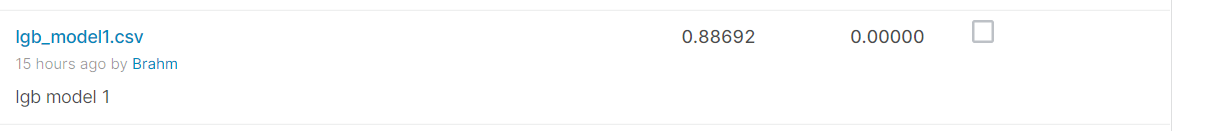

In [3]:
from IPython.display import Image
Image("Capture_lgb.PNG")


# feature importance in LightGBM:

In [209]:
lgb_model1.feature_importance()

array([177,  18,   0, 136,  45,   0,   7, 105,   1,   8,  53,   8,   0,
         1,   0,   0,   0,   1,   0,   0,   3,   5,   0,  17,   0,   5,
         0,   0,  25,  44,   0, 320,   0,  82, 304, 130,   5,   0],
      dtype=int32)

In [210]:
train_df.drop(cols,axis=1).columns

Index(['index', 'networkDomain', 'city', 'operatingSystem', 'metro', 'region',
       'channelGrouping', 'referralPath', 'country', 'source', 'medium',
       'keyword', 'browser', 'deviceCategory', 'continent', 'subcontinent',
       'timeOnSite_sum', 'timeOnSite_min', 'timeOnSite_max', 'timeOnSite_mean',
       'pageviews_sum', 'pageviews_min', 'pageviews_max', 'pageviews_mean',
       'hits_sum', 'hits_min', 'hits_max', 'hits_mean',
       'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num',
       'isMobile_max'],
      dtype='object')

# classification model feature importance:

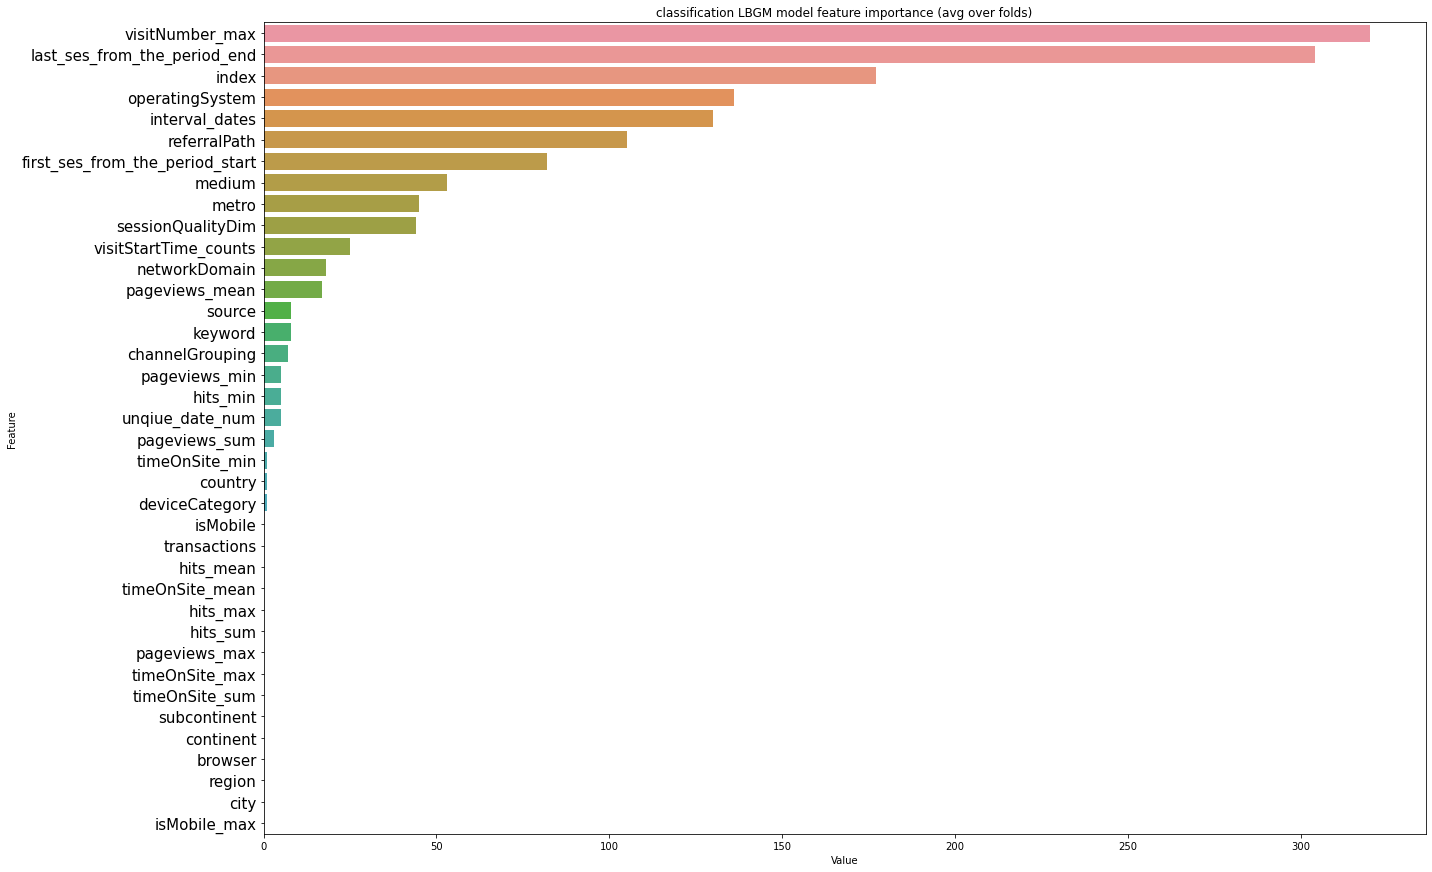

In [211]:
import seaborn as sns
feature_imp_df1=pd.DataFrame(zip(lgb_model1.feature_importance(),train_df.drop(cols,axis=1).columns),columns=['Value','Feature'])
plt.figure(figsize=(20,12))
plt.rc('ytick',labelsize=15)
sns.barplot(x='Value',y='Feature',data=feature_imp_df1.sort_values(by='Value',ascending=False),orient='h')
plt.tight_layout()
plt.title('classification LBGM model feature importance (avg over folds)')
plt.show()

# Regression model feature importance:

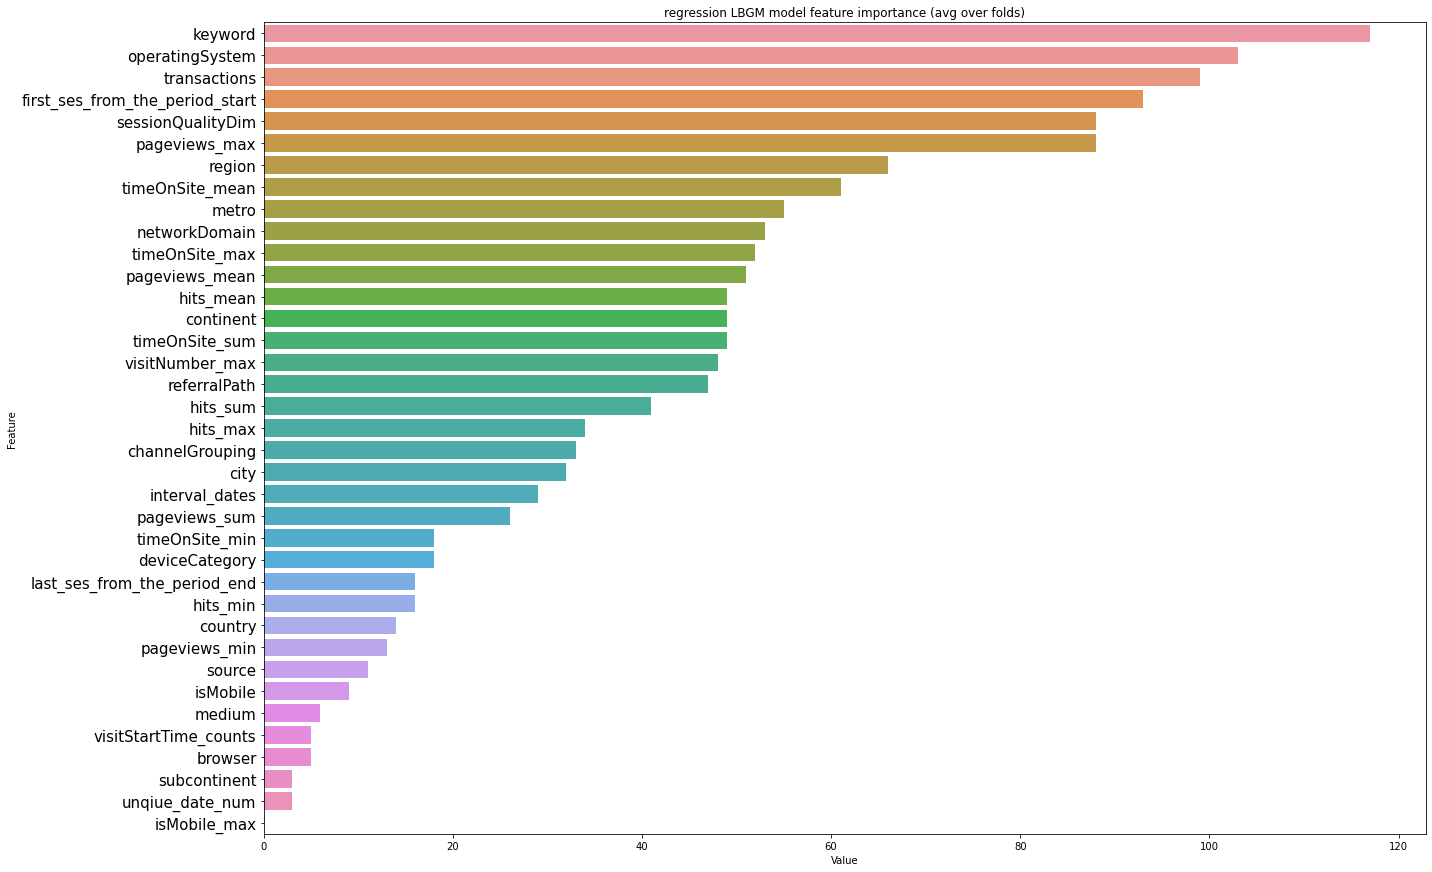

In [118]:
import seaborn as sns
feature_imp_df2=pd.DataFrame(zip(lgb_model2.feature_importance(),train_df.drop(cols,axis=1).columns),columns=['Value','Feature'])
plt.figure(figsize=(20,12))
plt.rc('ytick',labelsize=15)
sns.barplot(x='Value',y='Feature',data=feature_imp_df2.sort_values(by='Value',ascending=False))
plt.tight_layout()
plt.title('regression LBGM model feature importance (avg over folds)')
plt.show()

# Model 2 Random Forest:

Hyper -parameter tuning for random forest classifier :

In [137]:
cols=['is_returned','fullVisitorId','revenue']

In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
gridParams1={
    'n_estimators':[100,200,400,800,1000],
    'max_depth':[2,6,8,10],
    'min_samples_split':[2,3,5,7],
    'min_samples_leaf':[1,2,4]
}
classifier=RandomForestClassifier(n_jobs=-1)

In [15]:
# RandomizedSearchCV to hypertune the parameters
cv_iterator = KFold(n_splits = 5, random_state = 23)
grid=RandomizedSearchCV(classifier,gridParams1,cv=cv_iterator,verbose=10)
# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time grid.fit(train_df.drop( ['is_returned', 'revenue', 'fullVisitorId','isMobile_max'],axis=1),train_df['is_returned'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6, score=0.995, total= 5.5min
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.5min remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6, score=0.995, total= 5.6min
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.1min remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6, score=0.994, total= 5.5min
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.6min remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6, score=0.993, total= 5.5min
[CV] n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 22.1min remaining:    0.0s


[CV]  n_estimators=800, min_samples_split=3, min_samples_leaf=2, max_depth=6, score=0.996, total= 5.5min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 27.7min remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2, score=0.995, total=  34.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.2min remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2, score=0.995, total=  34.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 28.8min remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2, score=0.994, total=  34.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 29.4min remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2, score=0.993, total=  34.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 30.0min remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=2, score=0.996, total=  34.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2, score=0.995, total= 1.1min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2, score=0.993, total= 1.1min
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_depth=2, score=0.996, total= 1.1min
[CV] n_estimators=1000, min_samples_split=7, min_samples_leaf=4, max_depth=10 
[CV]  n_estimators=1000, min_samples_split=7, min_samples_leaf=4, max_depth=10, score=0.995, total=10.6min
[CV] n_estimators=1000, min_samples_split=7, min_samples_leaf=4, max_depth=10 
[CV]  n_estimators=1000, min_samples_split=7, min_samples_leaf=4, max_depth=10, scor

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 133.0min finished


CPU times: user 2h 43min, sys: 36.6 s, total: 2h 43min 36s
Wall time: 2h 31min 54s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [2, 6, 8, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [100, 200, 400, 800,
                                                         1000]},
                   verbose=10)

In [17]:
# Print the best parameters found

print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 1000, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 10}
0.9947973592045505


# Hyper-parameter tuning for random forest regressor :

In [141]:
from sklearn.ensemble import RandomForestRegressor
gridParams2= {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4],
              "max_features": ['auto', 'sqrt'],
              'bootstrap': [True, False]
             }




regressor=RandomForestRegressor()

In [139]:
# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(regressor, 
                          gridParams2,
                          cv=3,n_jobs=-1,verbose=10,scoring='neg_mean_squared_error'
                          )


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters


%time random_search.fit(train_df.drop(cols, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.4min remaining:   47.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.5min remaining:   27.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.9min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


CPU times: user 9.75 s, sys: 3.77 s, total: 13.5 s
Wall time: 2min 28s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 9, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='neg_mean_squared_error', verbose=10)

In [41]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
-13.037576099355652


In [143]:
classfier=RandomForestClassifier(n_estimators= 1000, min_samples_split= 7, min_samples_leaf= 4, max_depth= 10,n_jobs=-1)
regressor=RandomForestRegressor(n_estimators=200, min_samples_split= 2, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 5, bootstrap= False,n_jobs=-1)

classfier.fit(train_df.drop(cols,axis=1),train_df['is_returned'])
regressor.fit(train_df.drop(cols,axis=1)[train_df['is_returned']==1],train_df['revenue'][train_df['is_returned']==1])   
              
score_sum_rf=0
for i in range(10):
    print("training model : ",i)     
    cl_rd= classfier.predict_proba(test_df.drop(cols,axis=1))[:,1]
    reg_rf=regressor.predict(test_df.drop(cols,axis=1))          
    score_sum_rf+= cl_rd*reg_rf
print('Final score',score_sum_rf/10)   
score_sum_rf=score_sum_rf/10


training model :  0
training model :  1
training model :  2
training model :  3
training model :  4
training model :  5
training model :  6
training model :  7
training model :  8
training model :  9
Final score [0.00354401 0.00137025 0.00103046 ... 0.00018735 0.00149899 0.00080591]


In [195]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = score_sum_rf

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [145]:
pred_df.to_csv("pred_rf.csv", index=False)

In [196]:
test_data = pd.read_csv('./preprocessed_test_df1.csv', dtype={'fullVisitorId':'str'},index_col=0) 
test_data['totals.totalTransactionRevenue'].fillna(0,inplace=True)
sam_group=test_data.groupby('fullVisitorId')[['totals.totalTransactionRevenue']].sum().apply(np.log1p,axis=1).reset_index()
res=pd.merge(pred_df,sam_group,left_on='fullVisitorId',right_on='fullVisitorId')


rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))

print(rms)

2.111297153861249


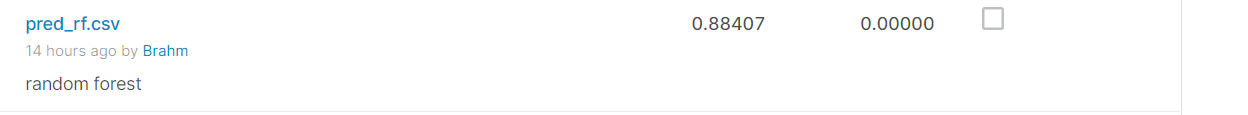

In [4]:
from IPython.display import Image
Image("Capture_rf.PNG")

# Model:3 Logistic regression(for classification)+ Linear regression(for regression):

# Logistic regression:

In [148]:
%%time
from sklearn.linear_model import SGDClassifier
cols=['is_returned', 'revenue', 'fullVisitorId']
gridparams1={'alpha':[10**i for i in range(-6,4)]}

model=SGDClassifier(loss='log',penalty='l2',class_weight='balanced')

clf=GridSearchCV(model,gridparams1,cv=5,verbose=2,n_jobs=-1,scoring='roc_auc')
grid=clf.fit(train_df.drop(cols,axis=1),train_df['is_returned'])



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.1min finished


CPU times: user 3min 50s, sys: 3.26 s, total: 3min 53s
Wall time: 18min 57s


In [149]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 100}
0.8036743257833896


In [152]:
%%time
from sklearn.linear_model import SGDRegressor
cols=['is_returned', 'revenue', 'fullVisitorId']
gridparams2={'alpha':[10**i for i in range(-4,4)]}
model=SGDRegressor(loss='squared_loss',penalty='l2')
reg=GridSearchCV(model,gridparams2,cv=5,verbose=2,n_jobs=-1,scoring='neg_root_mean_squared_error')
grid=reg.fit(train_df.drop(cols,axis=1)[train_df['is_returned']==1],train_df['is_returned'][train_df['is_returned']==1])
print(grid.best_params_)
print(grid.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.5s finished


{'alpha': 0.0001}
-3.4571170874072786e+18
CPU times: user 632 ms, sys: 124 ms, total: 756 ms
Wall time: 3.11 s


In [153]:
clf=SGDClassifier(alpha= 100,loss='log',penalty='l2',class_weight='balanced')
reg=SGDRegressor(alpha=0.0001,loss='squared_loss',penalty='l2')

clf.fit(train_df.drop(cols,axis=1),train_df['is_returned'])
reg.fit(train_df.drop(cols,axis=1)[train_df['is_returned']==1],train_df['is_returned'][train_df['is_returned']==1])


clf_pred=clf.predict_proba(test_df.drop(cols,axis=1))[:,1]
reg_pred=reg.predict(test_df.drop(cols,axis=1))

score=clf_pred*reg_pred

In [192]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = score

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [158]:
pred_df.to_csv("linear_models1.csv", index=False)

In [193]:
pred_df.shape

(296530, 2)

In [160]:
! ls linear_models1.csv

linear_models1.csv


In [194]:
#test_data = pd.read_csv('./preprocessed_test_df1.csv', dtype={'fullVisitorId':'str'},index_col=0) 
test_data['totals.totalTransactionRevenue'].fillna(0,inplace=True)
sam_group=test_data.groupby('fullVisitorId')[['totals.totalTransactionRevenue']].sum().apply(np.log1p,axis=1).reset_index()
res=pd.merge(pred_df,sam_group,left_on='fullVisitorId',right_on='fullVisitorId')

res = pd.merge(pred_df, sam, left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))

print(rms)

3.076196394859406e+18


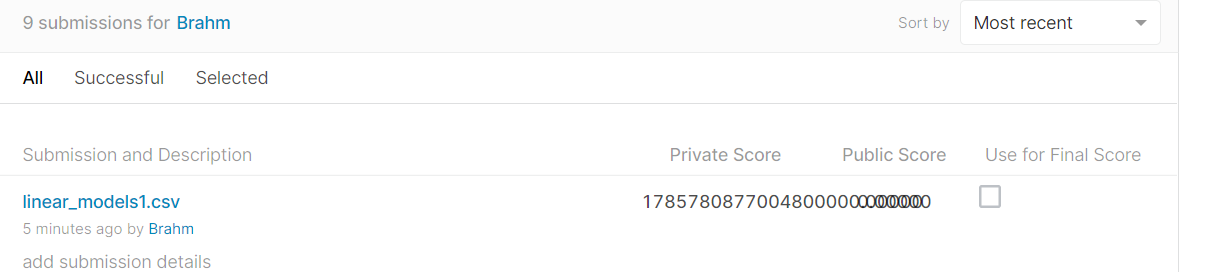

In [5]:
from IPython.display import Image
Image("Capture.PNG")

* Observations:
  * so from the above models we observed that linear models (logistic and linear) are performing very poor and tree based models are performing highly accurate.
  * Both random forest and lightGBM are giving similar results.

* Observations:
  * so from the above models we observed that linear models (logistic and linear) are performing very poor and tree based models are performing highly accurate.
  * Both random forest and lightGBM are giving similar results.

# Feature importance:
 https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15   
 https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7

* Here we will see which features are really useful., so that we will use only those features so that we can reduce the dimenssionality of data and computationl time also.

* So for that we are using 'recursive feature elimination'


## Recursive feature elimination:
* The recursive feature elimination idea is similar to backward feature selection.
* First we need to specify the base model(Here base model has to return the feature importances). so that the algorithm first     train the model on all features of the data set.
* Now it will take feature importances of all features., Now by removing least importance feaures it will re-train the mdoel on   new set of features., so this operation will iteratively run for different set of features.
* Finally the feature set which is gibing best accuracy those features are selected as our final features.

In [197]:
cols = ['is_returned', 'revenue', 'fullVisitorId']

In [206]:
# Define LightGBM Regressor model as our base model: We can use any model just using it because it is faster
estimator=lgb.LGBMRegressor(objective = "regression",metric= "rmse",max_leaves=128,
                          num_leaves = 8,min_child_samples = 20 , learning_rate = 0.010,
                          subsample = 0.9,colsample_bytree = 1,bagging_frequency = 1,
                          n_estimators = 200, reg_alpha = 1,reg_lambda = 0,boosting_type = "gbdt")

In [207]:
from sklearn.feature_selection import RFECV
rfecv=RFECV(estimator,step=1)  #step denotes the number of features we want to eliminate per step
%time rfecv.fit(train_df.drop(cols,axis=1)[train_df['is_returned']==1],train_df['revenue'][train_df['is_returned']==1])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Curr

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: 

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: 

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: 

In [209]:
print('Optimal number of features are:',rfecv.n_features_)

Optimal number of features are: 19


In [210]:
# The mask of selected features.
rfecv.support_

array([ True,  True, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
        True, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
       False])

In [212]:
train_df_copy=train_df.drop(cols,axis=1)


In [213]:
train_df_copy.drop(train_df_copy.columns[np.where(rfecv.support_==False)[0]],axis=1,inplace=True)

In [215]:
train_df_copy.columns

Index(['index', 'networkDomain', 'operatingSystem', 'metro', 'referralPath',
       'country', 'timeOnSite_sum', 'timeOnSite_max', 'pageviews_sum',
       'pageviews_max', 'pageviews_mean', 'hits_sum', 'hits_max', 'hits_mean',
       'sessionQualityDim', 'isMobile', 'transactions',
       'first_ses_from_the_period_start', 'interval_dates'],
      dtype='object')

In [219]:
imp_features=['index', 'networkDomain', 'operatingSystem', 'metro', 'referralPath',
       'country', 'timeOnSite_sum', 'timeOnSite_max', 'pageviews_sum',
       'pageviews_max', 'pageviews_mean', 'hits_sum', 'hits_max', 'hits_mean',
       'sessionQualityDim', 'isMobile', 'transactions',
       'first_ses_from_the_period_start', 'interval_dates']
target_features=cols

In [220]:
final_features=imp_features+target_features

In [221]:
train_df_imp=train_df[final_features]
test_df_imp=test_df[final_features]

# Building models only on important features :

Hyper-parameter tuning for classification model:

In [228]:
gridParams= {
    'learning_rate': [0.005,0.01,0.015],    #Learning rate
    'n_estimators': [40,100,200],           #number of boosting iterations  
    'num_leaves': [6,8,12,15,16],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['binary_logloss'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [1,20]            #Minimum number of data points needed in a child (leaf) node.
            }

In [229]:
clf_rf=lgb.LGBMClassifier()
# RandomizedSearchCV to hypertune the parameters

grid_rf= RandomizedSearchCV(clf_rf, 
                          gridParams,
                          cv=3)

# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time grid_rf.fit(train_df_imp.drop(cols, axis=1) , train_df_imp['is_returned'])

[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=12, max_leaves=128 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=128 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=12, max_leaves=128 will be ignored. Current value: num_leaves=12
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be igno

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [232]:
# Print the best parameters found

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 16, 'n_estimators': 200, 'min_child_samples': 20, 'metric': 'binary_logloss', 'max_leaves': 512, 'learning_rate': 0.005, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}
0.9938152810932182


In [233]:
gridParams= {
    'learning_rate': [0.005,0.01,0.015],    #Learning rate
    'n_estimators': [40,100,200],           #number of boosting iterations  
    'num_leaves': [6,8,12,15,16],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['rmse'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [1,20]            #Minimum number of data points needed in a child (leaf) node.
            }

In [234]:
# Define LightGBM Regressor model

lgb_reg = lgb.LGBMRegressor()

In [242]:
grid_regrf=RandomizedSearchCV(lgb_reg,gridParams,cv=3,n_jobs=-1)
%time grid_regrf.fit(train_df_imp.drop(cols,axis=1)[train_df_imp['is_returned']==1],train_df_imp['revenue'][train_df_imp['is_returned']==1])

CPU times: user 1.5 s, sys: 3.1 s, total: 4.6 s
Wall time: 4.89 s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [243]:
print(grid_regrf.best_params_
print(grid_regrf.best_score_)

{'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 200, 'min_child_samples': 1, 'metric': 'rmse', 'max_leaves': 128, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
0.006672503577251576


In [247]:
# classification model params:

params_lgb1=grid_rf.best_params_

params_lgb2=grid_regrf.best_params_

# Define dataset for Classification model to determine whether customer would return during test time window.
dtrain_retuned_imp=lgb.Dataset(train_df_imp.drop(cols, axis=1) , train_df_imp['is_returned'])

# Define dataset for Regression model, picking only the customers who returned during test time window.
dtrain_revenue_imp=lgb.Dataset(train_df_imp.drop(cols,axis=1)[train_df_imp['is_returned']==1],train_df_imp['revenue'][train_df_imp['is_returned']==1])

In [251]:
#Running Lightgbm model for 10 iterations and took average of those.
#Source :- https://www.kaggle.com/kostoglot/winning-solution

pr_lgb_sum = 0    #Variable to store predictions.

for i in range(10):
    print('Iteration num:',i)
    
    #Classification model to predict whether customer will return in test window.
    lgb_model1=lgb.train(params_lgb1,dtrain_retuned_imp)
    
    clf_pred=lgb_model1.predict(test_df_imp.drop(cols,axis=1))
    
    #regression model to predict the transaction amount for the customers who returned in that time window.
    
    lgb_model2 = lgb.train(params_lgb2, dtrain_revenue)
    reg_pred = lgb_model2.predict(test_df_imp.drop(cols, axis=1))

    
    #Calculating final prediction as product of above two amounts.
    pr_lgb_sum = pr_lgb_sum + clf_pred*reg_pred

#Taking average value from above iterations the model was run.
pr_final2 = pr_lgb_sum/10

Iteration num: 0
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 8796, number of negative: 1413419
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 1422215, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006185 -> initscore=-5.079470
[LightGBM] [Info] Start training from score -5.079470
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[Ligh

[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] num_leaves is set=6, max_leaves=128 will be ignored. Current value: num_leaves=6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2919
[LightGBM] [Info] Number of data points in the train set: 8796, number of used features: 19
[LightGBM] [Info] Start training from score 0.814668
Iteration num: 6
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Num

In [252]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pr_final2
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [254]:
test_data

,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent
channelGrouping,,,,,,,,,,,,,,,,,,,,,
Organic Search,"[{'index': '4', 'value': 'APAC'}]",2018-05-11,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1526099341,2,1526099341,Chrome,Android,True,...,1,973.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)
Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1526064483,166,1526064483,Chrome,Macintosh,False,...,1,49.0,0.0,0.0,(not set),(direct),(none),(not set),(not set),(not set)
Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1526067157,2,1526067157,Chrome,Chrome OS,False,...,1,24.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)
Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1526107551,4,1526107551,Chrome,iOS,True,...,1,25.0,0.0,0.0,(not set),(direct),(none),(not set),(not set),(not set)
Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1526060254,1,1526060254,Internet Explorer,Windows,True,...,1,49.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2018-09-07,6701149525099562370,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",1536353803,1,1536353803,Chrome,Android,True,...,1,111.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)
Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-09-07,6154541330147351453,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1536388075,1,1536388075,Chrome,Windows,False,...,1,10.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)
Organic Search,[],2018-09-07,6013469762773705448,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",1536351791,3,1536351791,Firefox,Windows,False,...,1,63.0,0.0,0.0,(not set),google,organic,others,(not set),(not set)


In [255]:
test_data = test_data.groupby('fullVisitorId')[["totals.totalTransactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [257]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))

print(rms)

2.117450018671358


# Random-Forest models:
hyper-paramter tuning of random forest classifier:

In [259]:
test_df.to_pickle('final_test_df')

In [264]:
train_df.to_pickle('final_train_df')

In [265]:
test_df_imp.to_pickle('final_test_imp_df')

In [144]:
train_df_imp=pd.read_pickle('final_train_imp_df')

In [145]:
test_df_imp=pd.read_pickle('final_test_imp_df')

In [281]:
gridParams = {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4]
             }

classifier = RandomForestClassifier()

In [273]:
# RandomizedSearchCV to hypertune the parameters

grid = RandomizedSearchCV(classifier, 
                          gridParams,
                          cv=3,n_jobs=-1,verbose=30)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time grid.fit(train_df_imp.drop(cols, axis=1) , train_df_imp['is_returned'])


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 53.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 56.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 59

CPU times: user 45min 11s, sys: 3.44 s, total: 45min 14s
Wall time: 2h 32min 45s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 7, 9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=30)

In [274]:
# Print the best parameters found

print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
0.9938314530508358


In [282]:
gridParams = {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4],
              "max_features": ['auto', 'sqrt'],
              'bootstrap': [True, False]
             }

reg = RandomForestRegressor()

In [283]:
# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(reg, 
                          gridParams,
                          cv=3,n_jobs=-1,verbose=10
                          )


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time random_search.fit(train_df_imp.drop(cols, axis=1)[train_df_imp['is_returned']==1], train_df_imp['revenue'][train_df_imp['is_returned']==1])


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   40.7s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   53.1s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.0min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


CPU times: user 4.81 s, sys: 4.38 s, total: 9.19 s
Wall time: 1min 9s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 7, 9, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=10)

In [284]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}
-0.03352552261325711


In [286]:
classifier = RandomForestClassifier(n_estimators= 800,min_samples_split= 2,min_samples_leaf= 1,max_depth= 10,n_jobs=-1)
regressor  = RandomForestRegressor(n_estimators= 400,min_samples_split=2,min_samples_leaf= 2,max_features= 'sqrt',
                                  max_depth=7,bootstrap= False,n_jobs=-1)

classifier.fit(train_df_imp.drop(cols, axis=1) , train_df_imp['is_returned'])
regressor.fit(train_df_imp.drop(cols, axis=1)[train_df_imp['is_returned']==1], train_df_imp['revenue'][train_df_imp['is_returned']==1])

final_pred = 0             

for i in range(10):
    print("training model : ",i)
     
    classifier_pred = classifier.predict_proba(test_df_imp.drop(cols, axis=1))[:,1]
    regressor_pred  = regressor.predict(test_df_imp.drop(cols, axis=1))
     
    final_pred      = final_pred + (classifier_pred*regressor_pred)

final_pred /=10 


training model :  0
training model :  1
training model :  2
training model :  3
training model :  4
training model :  5
training model :  6
training model :  7
training model :  8
training model :  9


In [287]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = final_pred

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [288]:
test_data = pd.read_csv('./preprocessed_test_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_data = test_data.groupby('fullVisitorId')[["totals.totalTransactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [289]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))

print(rms)

2.1126200545531857


# Results and conclusions:

In [2]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["s.no","sub models", "RMSE(our calculation)","kaggle leaderboard private score"]


x.add_row(["Model-1:"," "," "," "])
print('\n')
x.add_row(["","LightGBM Classification (with logloss =0.994)","_","_"])
x.add_row(["","LightGBM Regression     (with rmse =0.0093)","_","_"])
x.add_row(["","Final model","2.11","0.88692"])

x.add_row([" "," "," "," "])
x.add_row(["Model-2:"," "," "," "])
print('\n')
x.add_row(["","Random-forest Classification (with logloss =0.994)","_","_"])
x.add_row(["","Random-forest Regression     (with rmse =-13.037)","_","_"])
x.add_row(["","Final model","2.112","0.88407"])

x.add_row([" "," "," "," "])
x.add_row(["Model-3:"," "," "," "])
print('\n')
x.add_row(["","Logistic regression Classification (with auc = 0.8045)","_","_"])
x.add_row(["","Linear Regression     (with rmse = -3.4571170874072786e+18","_","_"])
x.add_row(["","Final model","3.076e+18","178578077004887274213000.000"])


print(x)







+----------+------------------------------------------------------------+-----------------------+----------------------------------+
|   s.no   |                         sub models                         | RMSE(our calculation) | kaggle leaderboard private score |
+----------+------------------------------------------------------------+-----------------------+----------------------------------+
| Model-1: |                                                            |                       |                                  |
|          |       LightGBM Classification (with logloss =0.994)        |           _           |                _                 |
|          |        LightGBM Regression     (with rmse =0.0093)         |           _           |                _                 |
|          |                        Final model                         |          2.11         |             0.88692              |
|          |                                                   

After performing feature importace and considering only few features :


In [6]:
x = PrettyTable()

x.field_names = ["s.no","sub models", "RMSE(our calculation)","kaggle leaderboard private score"]


x.add_row(["Model-1:"," "," "," "])
print('\n')
x.add_row(["","LightGBM Classification (with logloss =0.993)","_","_"])
x.add_row(["","LightGBM Regression     (with rmse = 0.0066)","_","_"])
x.add_row(["","Final model","2.1174","0.8827"])

x.add_row([" "," "," "," "])
x.add_row(["Model-2:"," "," "," "])
print('\n')
x.add_row(["","Random-forest Classification (with logloss =0.993)","_","_"])
x.add_row(["","Random-forest Regression     (with rmse =-0.0335)","_","_"])
x.add_row(["","Final model","2.112","0.8830"])



print(x)





+----------+----------------------------------------------------+-----------------------+----------------------------------+
|   s.no   |                     sub models                     | RMSE(our calculation) | kaggle leaderboard private score |
+----------+----------------------------------------------------+-----------------------+----------------------------------+
| Model-1: |                                                    |                       |                                  |
|          |   LightGBM Classification (with logloss =0.993)    |           _           |                _                 |
|          |    LightGBM Regression     (with rmse = 0.0066)    |           _           |                _                 |
|          |                    Final model                     |         2.1174        |              0.8827              |
|          |                                                    |                       |                                

## summary:
* Reading data and delaing with json columns.
* Understanding business problem and metrics.
* Transforming the business problem into machine learning problem.
* Since we are solving this problem for advertisement team such they can spend appropriate amount in appropriate fields.
* Analysing the features and removing constant valued columns.
* Exploratory data analysis o each feature and writing observaitons.
* Data preprocessing and handling missing values.
* Feature engineerig and time series featurization.
* Understanding about 'hurdle model' stratergy.
* Building models.
* Trying out linear and non linear models and hyper-paramter tuning.
* Feature importance using 'recursive feature elimination'.
* Re-building the models on only important features.

# Deep-learning models:

In [182]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint,TensorBoard

from keras import optimizers

In [184]:
cols = ['is_returned', 'revenue', 'fullVisitorId']

In [183]:
test_df=pd.read_pickle('final_test_df')
train_df=pd.read_pickle('final_train_df')

In [169]:
train_df.shape

(1422215, 40)

In [170]:
BATCH_SIZE=128
n_features=1
epochs=20
lr=0.0001


In [303]:
model_clf=Sequential()
model_clf.add(Dense(256, kernel_initializer='glorot_normal',activation='relu',input_dim=37))
model_clf.add(Dense(128, kernel_initializer='glorot_normal',activation='relu'))
model_clf.add(Dense(1,activation='sigmoid'))


In [304]:
optim=optimizers.Adam(lr=lr)
model_clf.compile(loss='binary_crossentropy',optimizer=optim)
model_clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               9728      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 42,753
Trainable params: 42,753
Non-trainable params: 0
_________________________________________________________________


In [305]:
history=model_clf.fit(train_df.drop(cols,axis=1),train_df['is_returned'],epochs=epochs,batch_size=BATCH_SIZE,verbose=1)


Epoch 1/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 18.5779
Epoch 2/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 12.2266
Epoch 3/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 10.1037
Epoch 4/20
1422215/1422215 [==============================] - 49s 34us/step - loss: 7.4532
Epoch 5/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 5.4457
Epoch 6/20
1422215/1422215 [==============================] - 49s 35us/step - loss: 3.7400
Epoch 7/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 3.2478
Epoch 8/20
1422215/1422215 [==============================] - 48s 34us/step - loss: 2.4569
Epoch 9/20
1422215/1422215 [==============================] - 50s 35us/step - loss: 1.6840
Epoch 10/20
1422215/1422215 [==============================] - 49s 35us/step - loss: 1.3874
Epoch 11/20
1422215/1422215 [==============================] - 49s 35us/step - loss: 

In [306]:
model_reg=Sequential()
model_reg.add(Dense(256, kernel_initializer='glorot_normal',activation='relu',input_dim=37))
model_reg.add(Dense(128, kernel_initializer='glorot_normal',activation='relu'))
model_reg.add(Dense(1,activation='sigmoid'))


In [308]:
optim=optimizers.Adam(lr=lr)
model_reg.compile(loss='mse',optimizer=optim)
model_reg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               9728      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 42,753
Trainable params: 42,753
Non-trainable params: 0
_________________________________________________________________


In [310]:
history2=model_reg.fit(train_df.drop(cols,axis=1)[train_df['is_returned']==1],train_df['revenue'][train_df['is_returned']==1],epochs=100,batch_size=BATCH_SIZE,verbose=1)

Epoch 1/100
8796/8796 [==============================] - 2s 209us/step - loss: 14.8769
Epoch 2/100
8796/8796 [==============================] - 0s 28us/step - loss: 14.8965
Epoch 3/100
8796/8796 [==============================] - 0s 26us/step - loss: 14.8961
Epoch 4/100
8796/8796 [==============================] - 0s 34us/step - loss: 14.9011
Epoch 5/100
8796/8796 [==============================] - 0s 29us/step - loss: 14.9009
Epoch 6/100
8796/8796 [==============================] - 0s 30us/step - loss: 14.9009
Epoch 7/100
8796/8796 [==============================] - 0s 29us/step - loss: 14.9009
Epoch 8/100
8796/8796 [==============================] - 0s 28us/step - loss: 14.9009
Epoch 9/100
8796/8796 [==============================] - 0s 29us/step - loss: 14.9009
Epoch 10/100
8796/8796 [==============================] - 0s 28us/step - loss: 14.9009
Epoch 11/100
8796/8796 [==============================] - 0s 31us/step - loss: 14.9009
Epoch 12/100
8796/8796 [===========================

In [312]:
clf_pred=model_clf.predict(test_df.drop(cols,axis=1))
reg_pred=model_reg.predict(test_df.drop(cols,axis=1))
reg_pred[reg_pred<0]=0

final_score=clf_pred*reg_pred

In [313]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = final_score

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [314]:
pred_df.to_csv('mlp_model_1.csv',index=False)

In [316]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))


In [317]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

Model validation metrics
RMSE: 2.12


# CNN model:

In [185]:
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

BATCH_SIZE=128
n_features=1
epochs=20
lr=0.0001
n_steps=37



In [172]:
# code refrence from sessions of applied ai
import os
tf.keras.backend.clear_session()
# For easy reset of notebook state.
checkpoint_path='./brahm.ckpt'
checkpoint_dir=os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback=ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True)

In [186]:
train = train_df.drop(cols, axis=1)

In [187]:
train.shape

(1422215, 37)

In [188]:
train=train.values.reshape(train.shape[0],train.shape[1],n_features)
train.shape

(1422215, 37, 1)

In [58]:
classification_model=Sequential()
classification_model.add(Conv1D(filters=64, kernel_size=2, activation='relu',input_shape=(n_steps,n_features)))
classification_model.add(MaxPooling1D(pool_size=2))
classification_model.add(Flatten())
classification_model.add(Dense(64,activation='relu'))                        
classification_model.add(Dense(1,activation='sigmoid'))                          

In [59]:
classification_model.compile(optimizer='adam', loss='binary_crossentropy')

In [60]:
classification_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 36, 64)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                73792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________


In [61]:
# https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
history=classification_model.fit(x=np.asarray(train).astype(np.float32),y=train_df['is_returned'],epochs=12,batch_size=BATCH_SIZE,verbose=1, callbacks=[cp_callback])

Epoch 1/12
1422215/1422215 [==============================] - 155s 109us/step - loss: 4.0942

Epoch 00001: saving model to ./brahm.ckpt
Epoch 2/12
1422215/1422215 [==============================] - 131s 92us/step - loss: 0.0323

Epoch 00002: saving model to ./brahm.ckpt
Epoch 3/12
1422215/1422215 [==============================] - 111s 78us/step - loss: 0.0310

Epoch 00003: saving model to ./brahm.ckpt
Epoch 4/12
1422215/1422215 [==============================] - 107s 76us/step - loss: 0.0304

Epoch 00004: saving model to ./brahm.ckpt
Epoch 5/12
1422215/1422215 [==============================] - 119s 84us/step - loss: 0.0303

Epoch 00005: saving model to ./brahm.ckpt
Epoch 6/12
1422215/1422215 [==============================] - 127s 89us/step - loss: 0.0301

Epoch 00006: saving model to ./brahm.ckpt
Epoch 7/12
1422215/1422215 [==============================] - 135s 95us/step - loss: 0.0300

Epoch 00007: saving model to ./brahm.ckpt
Epoch 8/12
1422215/1422215 [==========================

# Building regression model :

In [65]:
# code refrence from live session of applied ai

tf.keras.backend.clear_session()  # For easy reset of notebook state.

checkpoint_path = "./cp_reg.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [66]:
train = train_df.drop(cols, axis=1)[train_df['is_returned']==1]

In [67]:
train = train.values.reshape((train.shape[0], train.shape[1], n_features))
train.shape

(8796, 37, 1)

In [68]:
regression_model = keras.Sequential([
                                         keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)),
                                         keras.layers.MaxPooling1D(pool_size=2),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(50, activation='relu'),
                                         keras.layers.Dense(1,activation='sigmoid')
                                         ])

regression_model.compile(optimizer='adam', loss='mse')

In [69]:
regression_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                57650     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 57,893
Trainable params: 57,893
Non-trainable params: 0
_________________________________________________________________


In [72]:
regression_model.fit(x = np.asarray(train).astype(np.float32) ,y=train_df['revenue'][train_df['is_returned']==1], batch_size=64, epochs=100,callbacks=[cp_callback])

Train on 8796 samples
Epoch 1/100
8640/8796 [============================>.] - ETA: 0s - loss: 14.8704
Epoch 00001: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 146us/sample - loss: 14.9058
Epoch 2/100
8704/8796 [============================>.] - ETA: 0s - loss: 14.9477
Epoch 00002: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 2s 273us/sample - loss: 14.9058
Epoch 3/100
8768/8796 [============================>.] - ETA: 0s - loss: 14.9025
Epoch 00003: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 4s 487us/sample - loss: 14.9058
Epoch 4/100
8384/8796 [===========================>..] - ETA: 0s - loss: 14.8636
Epoch 00004: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 3s 351us/sample - loss: 14.9058
Epoch 5/100
8576/8796 [============================>.] - ETA: 0s - loss: 14.8720
Epoch 00005: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 3s 29

Epoch 42/100
8320/8796 [===========================>..] - ETA: 0s - loss: 14.6511
Epoch 00042: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 104us/sample - loss: 14.9058
Epoch 43/100
8768/8796 [============================>.] - ETA: 0s - loss: 14.9534
Epoch 00043: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 111us/sample - loss: 14.9058
Epoch 44/100
8448/8796 [===========================>..] - ETA: 0s - loss: 14.9904
Epoch 00044: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 125us/sample - loss: 14.9058
Epoch 45/100
8768/8796 [============================>.] - ETA: 0s - loss: 14.9534
Epoch 00045: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 113us/sample - loss: 14.9058
Epoch 46/100
8448/8796 [===========================>..] - ETA: 0s - loss: 14.9681
Epoch 00046: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 111us/sample - loss

Epoch 83/100
8384/8796 [===========================>..] - ETA: 0s - loss: 15.0973
Epoch 00083: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 169us/sample - loss: 14.9058
Epoch 84/100
8256/8796 [===========================>..] - ETA: 0s - loss: 14.9123
Epoch 00084: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 105us/sample - loss: 14.9058
Epoch 85/100
8704/8796 [============================>.] - ETA: 0s - loss: 15.0180
Epoch 00085: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 128us/sample - loss: 14.9058
Epoch 86/100
8704/8796 [============================>.] - ETA: 0s - loss: 15.0023
Epoch 00086: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 112us/sample - loss: 14.9058
Epoch 87/100
8512/8796 [============================>.] - ETA: 0s - loss: 14.9660
Epoch 00087: saving model to ./cp_reg.ckpt
8796/8796 [==============================] - 1s 117us/sample - loss

In [73]:
test=test_df.drop(cols,axis=1)
test=test.values.reshape((test.shape[0],test.shape[1],1))

In [74]:
classification_pred=classification_model.predict(np.asarray(test).astype(np.float32))
regression_pred=regression_model.predict(np.asarray(test).astype(np.float32))
regression_pred[regression_pred<0]=0

final_score=classification_pred*regression_pred

In [75]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = final_score

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [78]:

test_data = pd.read_csv('./preprocessed_test_df1.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_data = test_data.groupby('fullVisitorId')[["totals.totalTransactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))

In [79]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

Model validation metrics
RMSE: 2.12


In [80]:
pred_df.to_csv('cnn_model_predictions.csv',index=False)

In [104]:
!python3.7 -m pip install jupyter_contrib_nbextensions

     |████████████████████████████████| 20.9 MB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 861 kB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 479 kB 54.9 MB/s eta 0:00:01
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=d8efd075f927cb1d263aeb2c0688c2381d55b2d0905de1e43e31ce4d43f2e83d
  Stored in directory: /home/bpahs18/.cache/pip/wheels/a0/95/26/4cf34fb92765c95fb7851fd447511594bcc3a50e504bd09af9


  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=d742ea2f1289cff4d8ad8c2c2c5d7c3031ddd4a07e4a3d856e1903de377ac118
  Stored in directory: /home/bpahs18/.cache/pip/wheels/8d/c4/b5/e4b61f624036f83566580d61f24af7b73180b1361ee1ab3722
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator


In [103]:
logsdir=os.path.join('logs',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logsdir)

logs/20201117-204814


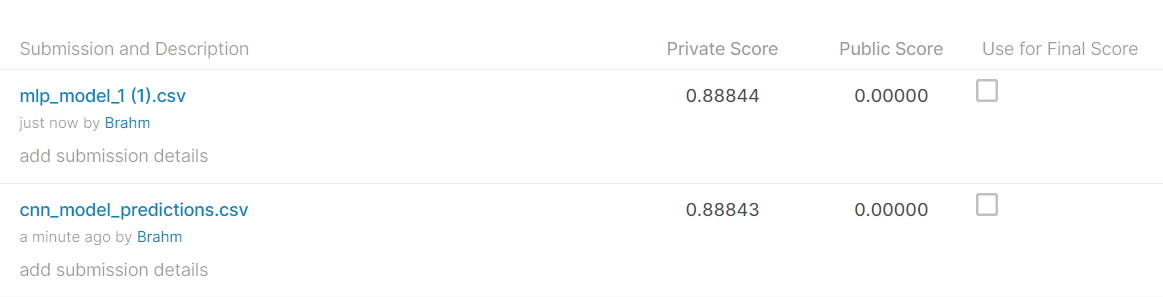

In [11]:
from IPython.display import Image
Image("Capture_dl.PNG")

## Conclusions and results:
* Here we are using simple mlp and cnn architectures for our data.
* Results are not significantly better., but deep learning models are also giving good score as tree based models.

In [10]:
x = PrettyTable()

x.field_names = ["s.no","sub models", "RMSE(our calculation)","kaggle leaderboard private score"]


x.add_row(["Model-1:"," "," "," "])
print('\n')
x.add_row(["","MLP model Classification (with binary_crossentropy = 0.1314)","_","_"])
x.add_row(["","MLP model Regression     (with mse =14.9009 )","_","_"])
x.add_row(["","Final model","2.12","0.88844"])

x.add_row([" "," "," "," "])
x.add_row(["Model-2:"," "," "," "])
print('\n')
x.add_row(["","CNN model Classification (with binary_crossentropy =  0.0297)","_","_"])
x.add_row(["","CNN model Regression     (with mse = 14.9058)","_","_"])
x.add_row(["","Final model","2.12","0.88843"])

print(x)






+----------+---------------------------------------------------------------+-----------------------+----------------------------------+
|   s.no   |                           sub models                          | RMSE(our calculation) | kaggle leaderboard private score |
+----------+---------------------------------------------------------------+-----------------------+----------------------------------+
| Model-1: |                                                               |                       |                                  |
|          |  MLP model Classification (with binary_crossentropy = 0.1314) |           _           |                _                 |
|          |         MLP model Regression     (with mse =14.9009 )         |           _           |                _                 |
|          |                          Final model                          |          2.12         |             0.88844              |
|          |                                

# Changing model architecture:

* debugging why train accuracy not changing
* we are dividing our train data 70 and 30 % and checking with various architectures.

In [189]:
train_df.shape[0]

1422215

In [190]:
train_set=train_df[:int(0.7*len(train_df))]
valid_set=    train_df[int(0.7*len(train_df)):]                   

# Building classification model:

In [191]:
import datetime
tf.keras.backend.clear_session()  # For easy reset of notebook state.
logsdir=os.path.join('logs',datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
#!tensorboard --logdir $logsdir

tensor_cb=TensorBoard(logsdir,histogram_freq=1)
model_classification = Sequential([
    Dense(256,kernel_initializer='glorot_normal', activation='relu',input_dim=train.shape[1]),
    Dropout(0.2),
    Dense(128,kernel_initializer='glorot_normal', activation='relu'),
    Dropout(0.3),
    
    Dense(128,kernel_initializer='glorot_normal', activation='relu'),
   
    Dropout(0.2),
    
    Dense(64,kernel_initializer='glorot_normal', activation='relu'),
    Dropout(0.2),
    Dense(64,kernel_initializer='glorot_normal', activation='relu'),
    Dense(1, activation='sigmoid')])
    
    
model_classification.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_classification.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               9728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [192]:
model_classification.fit(x=np.asarray(train_set.drop(cols,axis=1)).astype('float32'),y=train_set['is_returned']  ,
                         validation_data=(np.asarray(valid_set.drop(cols,axis=1)).astype('float32'),valid_set['is_returned'])
                         ,batch_size=BATCH_SIZE, epochs=15,verbose=1,callbacks=[tensor_cb])

Train on 995550 samples, validate on 426665 samples
Epoch 1/15
995550/995550 [==============================] - 97s 98us/step - loss: 4.0960 - accuracy: 0.9904 - val_loss: 0.0335 - val_accuracy: 0.9946
Epoch 2/15
995550/995550 [==============================] - 95s 96us/step - loss: 0.0481 - accuracy: 0.9934 - val_loss: 0.0337 - val_accuracy: 0.9946
Epoch 3/15
995550/995550 [==============================] - 91s 91us/step - loss: 0.0529 - accuracy: 0.9934 - val_loss: 0.0335 - val_accuracy: 0.9946
Epoch 4/15
995550/995550 [==============================] - 90s 90us/step - loss: 0.0489 - accuracy: 0.9934 - val_loss: 0.0337 - val_accuracy: 0.9946
Epoch 5/15
995550/995550 [==============================] - 87s 87us/step - loss: 0.0561 - accuracy: 0.9934 - val_loss: 0.0336 - val_accuracy: 0.9946
Epoch 6/15
995550/995550 [==============================] - 90s 90us/step - loss: 0.0469 - accuracy: 0.9934 - val_loss: 0.0337 - val_accuracy: 0.9946
Epoch 7/15
995550/995550 [======================

In [193]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [194]:
%tensorboard --logdir=logs

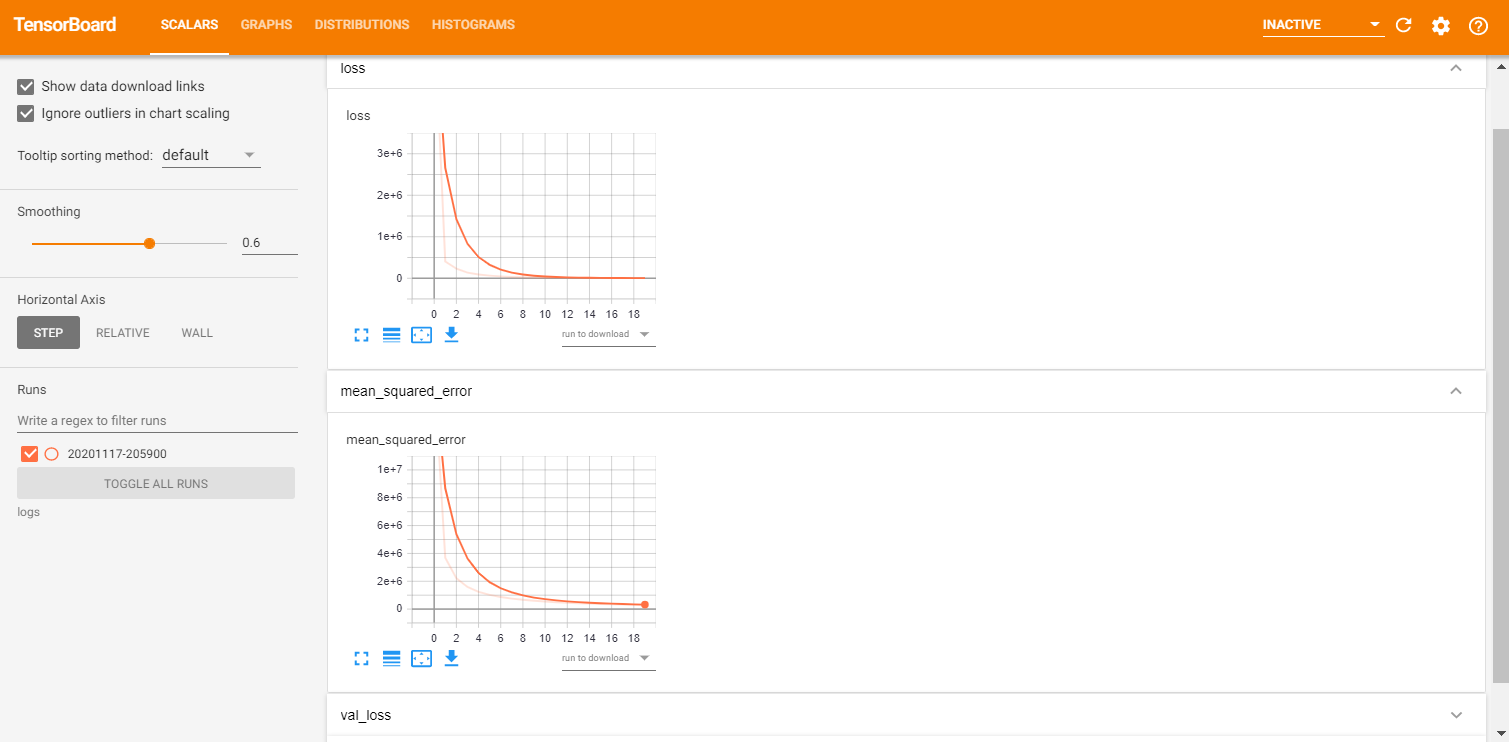

In [8]:
Image(filename="tfc1.PNG")

In [178]:
logsdir1=os.path.join('logs1',datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

tensor_cb=TensorBoard(logsdir1,histogram_freq=1)
model_regression = Sequential([
    Dense(256,kernel_initializer='glorot_normal', activation='relu',input_dim=train.shape[1]),
    Dropout(0.2),
    Dense(128,kernel_initializer='glorot_normal', activation='relu'),
    Dropout(0.3),
    
    Dense(128,kernel_initializer='glorot_normal', activation='relu'),
    Dropout(0.2),
    
    Dense(64,kernel_initializer='glorot_normal', activation='relu'),
    Dropout(0.2),
    Dense(64,kernel_initializer='glorot_normal', activation='relu'),
    Dense(1)])
    
adam = optimizers.Adam(lr=1e-2, decay=0.001)    
model_regression.compile(loss='mse',optimizer='adam',metrics=[keras.metrics.MeanSquaredError()])

model_regression.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               9728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [180]:
model_regression.fit(x=np.asarray(train_set.drop(cols,axis=1))[train_set['is_returned']==1].astype('float32'),y=train_set['revenue'][train_set['is_returned']==1]  ,
                         validation_data=(np.asarray(valid_set.drop(cols,axis=1))[valid_set['is_returned']==1].astype('float32'),valid_set['revenue'][valid_set['is_returned']==1])
                         ,batch_size=BATCH_SIZE, epochs=300,verbose=1,callbacks=[tensor_cb])

Train on 6504 samples, validate on 2292 samples
Epoch 1/300
6504/6504 [==============================] - 1s 94us/step - loss: 12673.8646 - mean_squared_error: 256699.6875 - val_loss: 438.7219 - val_mean_squared_error: 240820.8906
Epoch 2/300
6504/6504 [==============================] - 1s 98us/step - loss: 10178.9937 - mean_squared_error: 227035.8281 - val_loss: 221.8804 - val_mean_squared_error: 214547.3281
Epoch 3/300
6504/6504 [==============================] - 1s 137us/step - loss: 7950.5500 - mean_squared_error: 203538.0938 - val_loss: 27.7300 - val_mean_squared_error: 193422.3750
Epoch 4/300
6504/6504 [==============================] - 1s 122us/step - loss: 7233.7183 - mean_squared_error: 184425.4062 - val_loss: 311.3903 - val_mean_squared_error: 176134.8125
Epoch 5/300
6504/6504 [==============================] - 1s 117us/step - loss: 5527.7001 - mean_squared_error: 168624.9219 - val_loss: 221.0449 - val_mean_squared_error: 161654.3594
Epoch 6/300
6504/6504 [====================

6504/6504 [==============================] - 1s 112us/step - loss: 44.1255 - mean_squared_error: 19834.0352 - val_loss: 3.2610 - val_mean_squared_error: 19733.9766
Epoch 93/300
6504/6504 [==============================] - 1s 207us/step - loss: 41.7453 - mean_squared_error: 19634.7969 - val_loss: 2.6475 - val_mean_squared_error: 19536.7012
Epoch 94/300
6504/6504 [==============================] - 1s 113us/step - loss: 43.2492 - mean_squared_error: 19439.5059 - val_loss: 3.0254 - val_mean_squared_error: 19343.3574
Epoch 95/300
6504/6504 [==============================] - 1s 104us/step - loss: 31.2623 - mean_squared_error: 19248.0176 - val_loss: 2.6806 - val_mean_squared_error: 19153.7188
Epoch 96/300
6504/6504 [==============================] - 1s 92us/step - loss: 33.5745 - mean_squared_error: 19060.2441 - val_loss: 2.9841 - val_mean_squared_error: 18967.7891
Epoch 97/300
6504/6504 [==============================] - 1s 83us/step - loss: 37.3811 - mean_squared_error: 18876.1172 - val_los

6504/6504 [==============================] - 1s 90us/step - loss: 19.9365 - mean_squared_error: 10259.5547 - val_loss: 3.3020 - val_mean_squared_error: 10232.7422
Epoch 185/300
6504/6504 [==============================] - 1s 94us/step - loss: 20.4045 - mean_squared_error: 10206.0195 - val_loss: 3.2966 - val_mean_squared_error: 10179.4941
Epoch 186/300
6504/6504 [==============================] - 1s 94us/step - loss: 25.7421 - mean_squared_error: 10153.0674 - val_loss: 3.1236 - val_mean_squared_error: 10126.8164
Epoch 187/300
6504/6504 [==============================] - 1s 121us/step - loss: 22.3548 - mean_squared_error: 10100.6543 - val_loss: 3.0678 - val_mean_squared_error: 10074.6748
Epoch 188/300
6504/6504 [==============================] - 1s 109us/step - loss: 20.8748 - mean_squared_error: 10048.7695 - val_loss: 3.3497 - val_mean_squared_error: 10023.0557
Epoch 189/300
6504/6504 [==============================] - 1s 108us/step - loss: 19.2467 - mean_squared_error: 9997.4189 - val_

Epoch 231/300
6504/6504 [==============================] - 1s 88us/step - loss: 18.7035 - mean_squared_error: 8231.2227 - val_loss: 3.3438 - val_mean_squared_error: 8213.9707
Epoch 232/300
6504/6504 [==============================] - 1s 156us/step - loss: 19.2674 - mean_squared_error: 8196.7529 - val_loss: 3.3295 - val_mean_squared_error: 8179.6450
Epoch 233/300
6504/6504 [==============================] - 1s 166us/step - loss: 18.4451 - mean_squared_error: 8162.5698 - val_loss: 3.3193 - val_mean_squared_error: 8145.6050
Epoch 234/300
6504/6504 [==============================] - 1s 103us/step - loss: 18.3945 - mean_squared_error: 8128.6709 - val_loss: 3.3274 - val_mean_squared_error: 8111.8428
Epoch 235/300
6504/6504 [==============================] - 1s 103us/step - loss: 18.3328 - mean_squared_error: 8095.0503 - val_loss: 3.3195 - val_mean_squared_error: 8078.3638
Epoch 236/300
6504/6504 [==============================] - 1s 94us/step - loss: 20.3014 - mean_squared_error: 8061.7090 -

Epoch 278/300
6504/6504 [==============================] - 1s 93us/step - loss: 18.4534 - mean_squared_error: 6873.1899 - val_loss: 3.3296 - val_mean_squared_error: 6861.1660
Epoch 279/300
6504/6504 [==============================] - 1s 96us/step - loss: 18.2603 - mean_squared_error: 6849.1562 - val_loss: 3.3219 - val_mean_squared_error: 6837.2144
Epoch 280/300
6504/6504 [==============================] - 1s 90us/step - loss: 18.2404 - mean_squared_error: 6825.2881 - val_loss: 3.3022 - val_mean_squared_error: 6813.4277
Epoch 281/300
6504/6504 [==============================] - 1s 166us/step - loss: 18.2507 - mean_squared_error: 6801.5835 - val_loss: 3.3402 - val_mean_squared_error: 6789.8091
Epoch 282/300
6504/6504 [==============================] - 1s 94us/step - loss: 18.2742 - mean_squared_error: 6778.0483 - val_loss: 3.3421 - val_mean_squared_error: 6766.3550
Epoch 283/300
6504/6504 [==============================] - 1s 98us/step - loss: 18.2227 - mean_squared_error: 6754.6748 - va

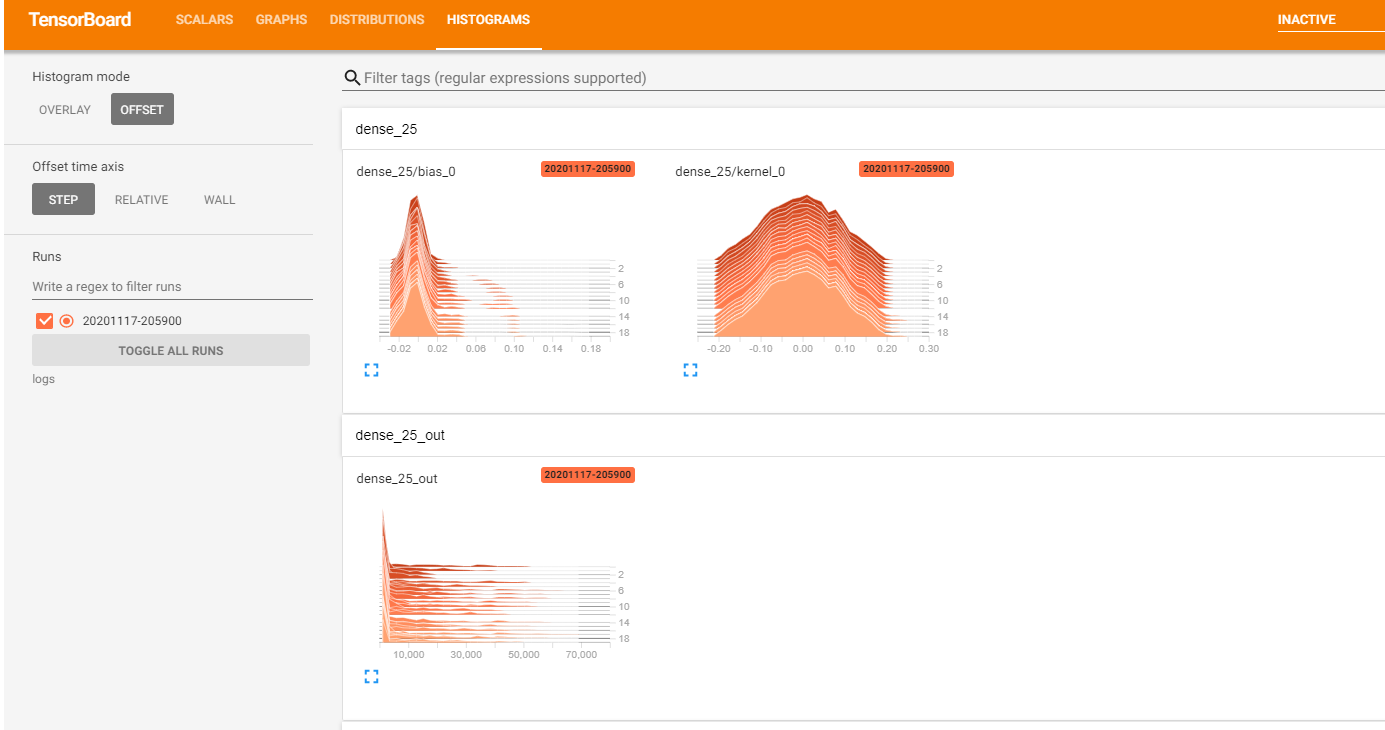

In [9]:
Image(filename="tfc2.PNG")

In [ ]:
classification_predictions = model_classification.predict(np.asarray(test_df.drop(cols, axis=1)).astype(np.float32) )

regression_predictions     = model_regression.predict(np.asarray(test_df.drop(cols, axis=1)).astype(np.float32) )
regression_predictions[regression_predictions<0] = 0


val_predictions = classification_predictions*regression_predictions

In [125]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = val_predictions

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [126]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.totalTransactionRevenue'], res['PredictedLogRevenue']))


In [127]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

Model validation metrics
RMSE: 2.12


# Future work

Building Ensemble Models:
* https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

* https://machinelearningmastery.com/implement-bagging-scratch-python/